# Using regression models to understand the relationship between environmental variables and bike lane use
## Research Question
How does the presence of the following variables affect Bay Wheels usage in different areas of San Francisco?
* Bay Wheels docking stations
* Meters of bike lanes and quality of those lanes
* Land use
* Hill gradient/elevation
* Density
* Average monthly temperature
* Days of rain
  
I plan to use a hexagonal grid to place all of these variables, and then run a SGD Regressor analysis to find how they interact. My model will predict how many bike rides start in a particular hexagon. I will train on a 12 month period, and then test on a 4 month period, for a 75:25 split.

## Data Wrangling

### Data Sources
* Bay Wheels Trip History: https://www.lyft.com/bikes/bay-wheels/system-data
* San Francisco Census Data: https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.2020.html#list-tab-1883739534
* Bike Share Stations: https://data.sfgov.org/Transportation/Bay-Area-Bike-Share-Stations/7jbp-yzp3/about_data
* Bike Lane: https://www.sfmta.com/maps/san-francisco-bike-network-map
* Land Use: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Map-of-San-Francisco-Land-Use-2023/k8rg-ihdq
* Population: https://data.census.gov/table/ACSDT5Y2022.B01003?q=population&t=Populations and People&g=010XX00US$1500000&y=2022
* U.S. Census Bureau, (2022), Total Population, American Community Survey, ACS 5-Year Estimates Detailed Tables, Table B01003, accessed on December 11, 2024, https://data.census.gov/table/ACSDT5Y2022.B01003?t=Populations and People&g=050XX00US06075$1500000&y=2022.
* Temperature: https://www.ncdc.noaa.gov/cdo-web/datatools/lcd

Number of points within bounding box: 338075


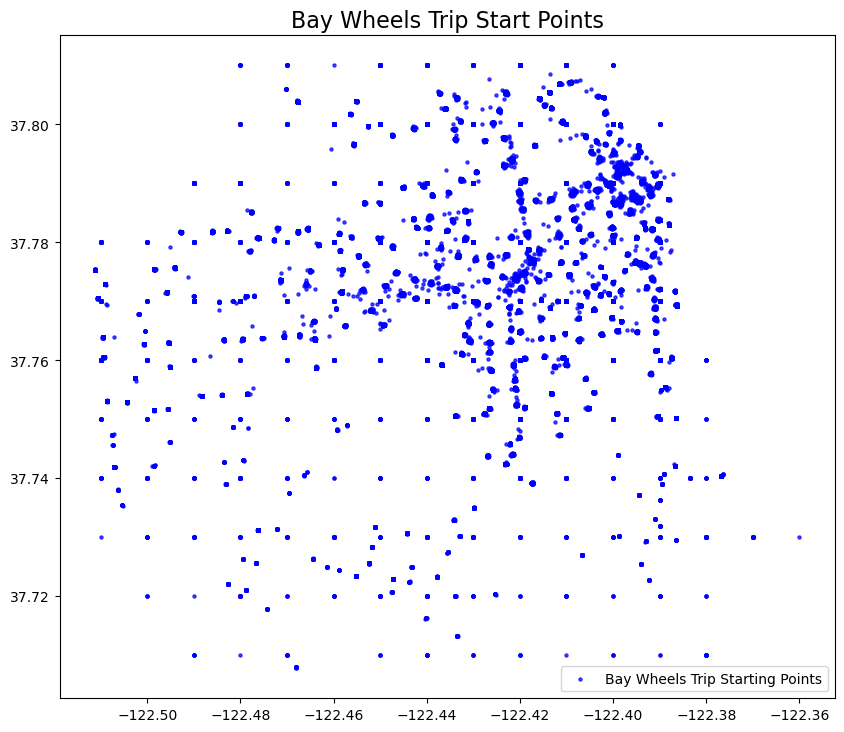

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from h3 import h3
from shapely.geometry import Polygon
from shapely.geometry import box
from shapely.geometry import Point

baywheels_df = pd.read_csv('data/baywheels_data/202410-baywheels-tripdata.csv')
baywheels_gdf = gpd.GeoDataFrame(
    baywheels_df, 
    geometry=gpd.points_from_xy(baywheels_df.start_lng, baywheels_df.start_lat),
    crs="EPSG:4326"  # WGS84 coordinate reference system
)

# Define the bounding box (min_x, min_y, max_x, max_y)
min_x, min_y, max_x, max_y = -122.529488, 37.694416, -122.354736, 37.813581

# Create a bounding box as a Shapely Polygon
bounding_box = box(min_x, min_y, max_x, max_y)

# Filter points within the bounding box
baywheels_gdf = baywheels_gdf[baywheels_gdf.geometry.apply(lambda point: point.within(bounding_box))]

# Verify the results
print(f"Number of points within bounding box: {len(baywheels_gdf)}")

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Bay Wheels stations (points)
baywheels_gdf.plot(ax=ax, color='blue', markersize=5, alpha=0.7, label='Bay Wheels Trip Starting Points')

# Add title, legend, and adjust
ax.set_title("Bay Wheels Trip Start Points", fontsize=16)
ax.legend()
plt.show()

As shown, we can pull from this the locations of starting points for trips.

### Clean contiguous San Francisco block level shapefile

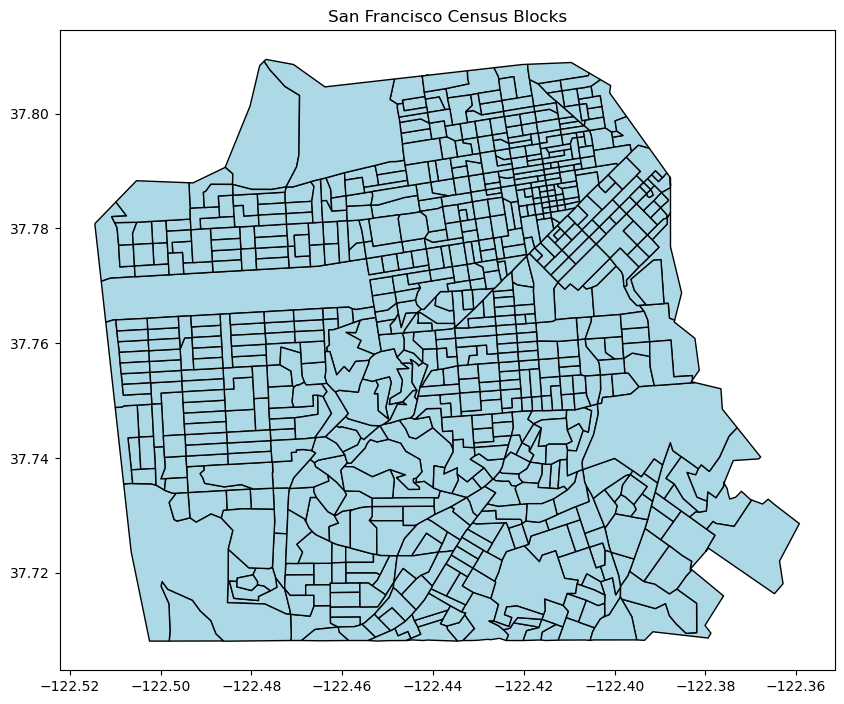

In [2]:
# create h3 map

# Load San Francisco boundary
cal_blocks = gpd.read_file("data/cb_2020_06_bg_500k/cb_2020_06_bg_500k.shp")

sf_blocks = cal_blocks[cal_blocks['COUNTYFP'] == '075']
sf_blocks = sf_blocks.to_crs("EPSG:4326")  # Ensure the CRS is WGS 84

# These extents should be in the format: [min_x, min_y, max_x, max_y] bbox finder
farallon_extent = [-123.027855,37.682787,-122.981850,37.712668]
treasure_island_extent = [-122.382570,37.806088,-122.358023,37.835784]
alameda_extent = [-122.338899,37.773391,-122.313149,37.800388]
alcatraz_extent = [-122.429515,37.823686,-122.416726,37.831414]

# Create bounding boxes (polygons) for each island from the extents
farallon_polygon = box(*farallon_extent)
treasure_island_polygon = box(*treasure_island_extent)
alameda_polygon = box(*alameda_extent)
alcatraz_polygon = box(*alcatraz_extent)

# Combine all island polygons into a single GeoDataFrame
islands = gpd.GeoDataFrame(geometry=[farallon_polygon, treasure_island_polygon, alameda_polygon, alcatraz_polygon], crs=sf_blocks.crs)

# Remove islands from the census blocks using spatial difference
sf_blocks_cleaned = sf_blocks[~sf_blocks.geometry.intersects(islands.unary_union)]

# Plot the cleaned San Francisco census blocks
fig, ax = plt.subplots(figsize=(10, 10))
sf_blocks_cleaned.plot(ax=ax, color='lightblue', edgecolor='black')

ax.set_title("San Francisco Census Blocks")
plt.show()

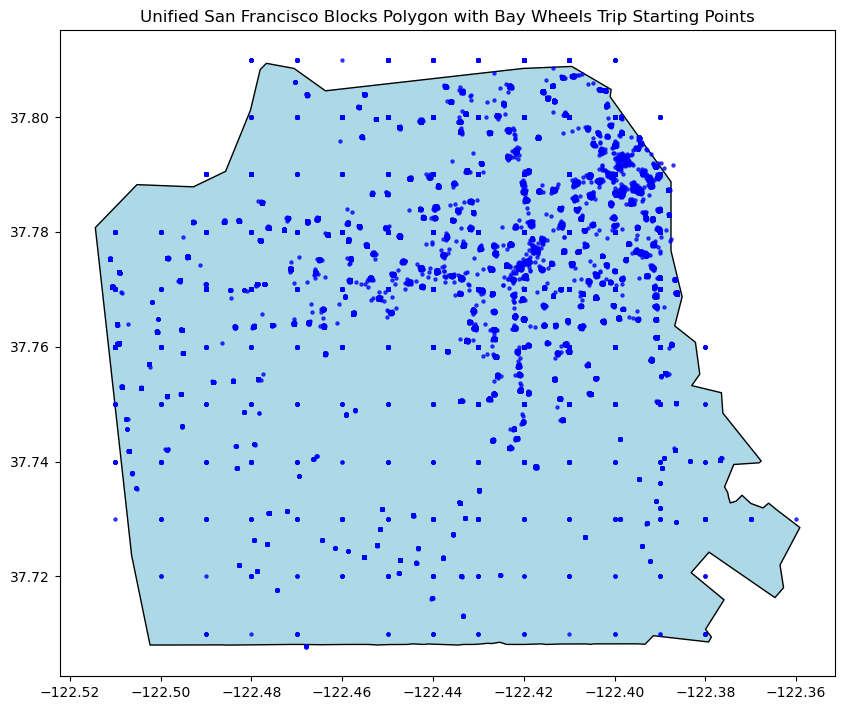

In [3]:
# Perform union of all geometries in sf_blocks_cleaned
unified_polygon = sf_blocks_cleaned.unary_union

# If you want to save the result as a new GeoDataFrame
sf_unified_gdf = gpd.GeoDataFrame({'geometry': [unified_polygon]}, crs=sf_blocks_cleaned.crs)

# Plot to verify
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
sf_unified_gdf.plot(ax=ax, color='lightblue', edgecolor='black')

# Plot Bay Wheels stations (points)
baywheels_gdf.plot(ax=ax, color='blue', markersize=5, alpha=0.7, label='Bay Wheels Trip Starting Points')

ax.set_title("Unified San Francisco Blocks Polygon with Bay Wheels Trip Starting Points")
plt.show()

In [4]:
# Filter points not within the unified polygon
remaining_points = baywheels_gdf[~baywheels_gdf.geometry.within(sf_unified_gdf.iloc[0].geometry)]

# Inspect the first 50 points
print(remaining_points.head())

              ride_id  rideable_type               started_at  \
23   42BFD84780B531A9  electric_bike  2024-10-31 08:38:07.329   
46   81CDE8A5D294C676  electric_bike  2024-10-12 15:55:27.878   
240  715BF5A96AD7C20D  electric_bike  2024-10-04 11:00:03.551   
245  1B694A0CE47BF060  electric_bike  2024-10-01 18:12:29.899   
252  52372F67361D4CF9  electric_bike  2024-10-13 17:06:40.540   

                    ended_at start_station_name start_station_id  \
23   2024-10-31 08:53:32.528                NaN              NaN   
46   2024-10-12 16:20:09.534                NaN              NaN   
240  2024-10-04 11:16:02.399                NaN              NaN   
245  2024-10-01 18:17:09.829                NaN              NaN   
252  2024-10-13 17:16:15.777                NaN              NaN   

              end_station_name end_station_id  start_lat  start_lng  \
23   Salesforce Transit Center       SF-G29-1      37.81    -122.43   
46   Mississippi St at 17th St         SF-N29      37.81  

As I can see from this, these are points that are actually outside this shapefile (ie- Daly City BART is not in San Francisco) and then everything that has NaN for start_station_name gets assigned one of these "dummy" start points. Need to remove all points that are NaN and see what we have left.

Original Bay Wheels DataFrame: 338075 rows
Cleaned Bay Wheels DataFrame: 321949 rows
Removed: 16126 rows


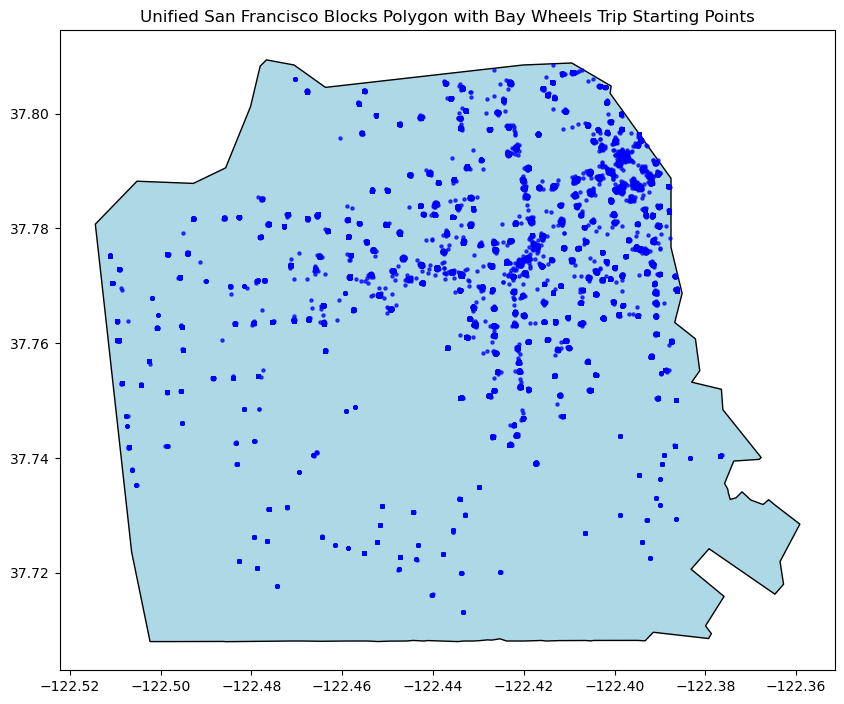

In [5]:
# Remove rows with NaN in 'start_station_name'
cleaned_baywheels_gdf = baywheels_gdf.dropna(subset=['start_station_name'])

# Filter points within the unified San Francisco boundary
cleaned_baywheels_gdf = cleaned_baywheels_gdf[cleaned_baywheels_gdf.geometry.within(sf_unified_gdf.iloc[0].geometry)]

# Verify the cleaned dataset
print(f"Original Bay Wheels DataFrame: {len(baywheels_gdf)} rows")
print(f"Cleaned Bay Wheels DataFrame: {len(cleaned_baywheels_gdf)} rows")
removed_rows = len(baywheels_gdf)-len(cleaned_baywheels_gdf)
print(f"Removed: {removed_rows} rows")

fig, ax = plt.subplots(figsize=(10, 10))
sf_unified_gdf.plot(ax=ax, color='lightblue', edgecolor='black')

# Plot Bay Wheels stations (points)
cleaned_baywheels_gdf.plot(ax=ax, color='blue', markersize=5, alpha=0.7, label='Bay Wheels Trip Starting Points')

ax.set_title("Unified San Francisco Blocks Polygon with Bay Wheels Trip Starting Points")
plt.show()

Looks sparser now, but those points that were aligned in a grid would mess up my analysis by introducing an inaccurate pattern. 

### Generate hexagons using H3 to cover San Francisco area

Number of hexagons: 237
Hex grid CRS: EPSG:2227
San Francisco CRS: EPSG:4326


/var/folders/6b/33d16tr12453_x5yvp1kg99c0000gn/T/ipykernel_29373/1565977280.py:46: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/6b/33d16tr12453_x5yvp1kg99c0000gn/T/ipykernel_29373/1565977280.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


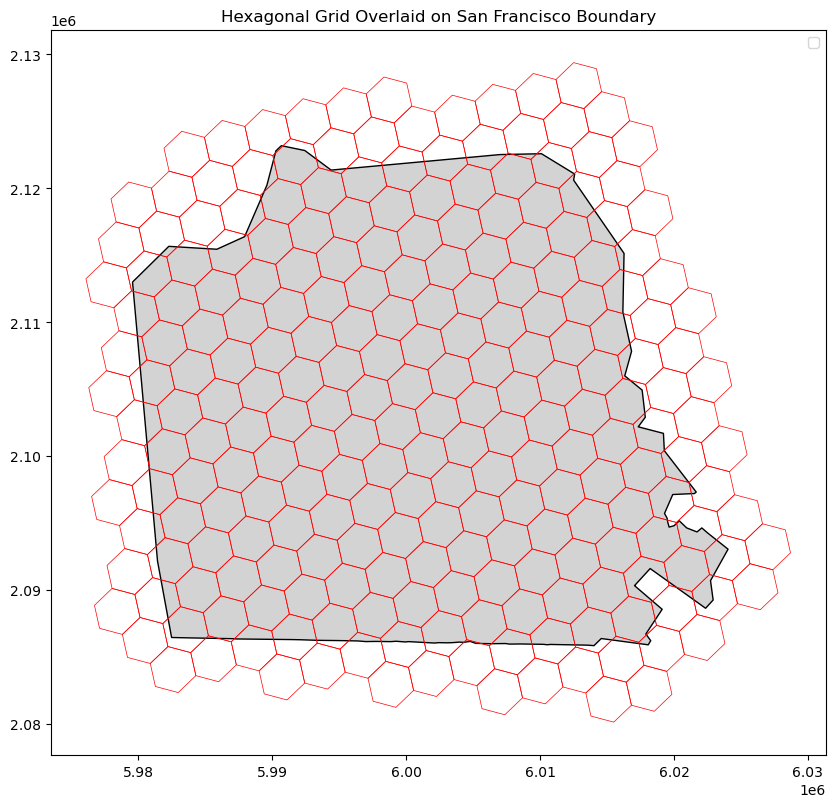

In [6]:
# Ensure the unified GeoDataFrame is in WGS84 for H3
sf_unified_gdf = sf_unified_gdf.to_crs("EPSG:4326")

# https://www.birdtheme.org/useful/v3tool.html Creating simple polygon to cover whole study area
sf_geojson = {'type': 'Polygon',
 'coordinates': [[[37.699970, -122.518409],
[37.696167, -122.381080],
[37.722785, -122.344688],
[37.746135, -122.355674],
[37.809633, -122.383140],
[37.823737, -122.395500],
[37.816685, -122.488883],
[37.797155, -122.523902]]] }

# Generate hexagons using H3
hexagons = list(h3.polyfill(sf_geojson, 8))

# Convert H3 hexagons to Shapely Polygons
hexagon_geometries = [Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in hexagons]

# Create GeoDataFrame from hexagon geometries, keeping CRS as EPSG:4326
hex_grid = gpd.GeoDataFrame({
    'h3_index': hexagons,
    'geometry': hexagon_geometries
}, crs="EPSG:4326")

# Reproject the hex grid to a CRS in meters (e.g., EPSG:2227)
hex_grid = hex_grid.to_crs("EPSG:2227")

# Verify the hex grid matches the San Francisco boundary
sf_unified_gdf = sf_unified_gdf.to_crs("EPSG:2227")

# Check the number of hexagons generated
print(f"Number of hexagons: {len(hexagons)}")

# Verify the CRS of both the hex_grid and sf_boundary
print(f"Hex grid CRS: {hex_grid.crs}")
print(f"San Francisco CRS: {sf_blocks.crs}")

fig, ax = plt.subplots(figsize=(10, 10))
sf_unified_gdf.plot(ax=ax, color='lightgray', edgecolor='black', label='San Francisco Boundary')
hex_grid.plot(ax=ax, color='none', edgecolor='red', linewidth=0.5, label='Hex Grid')

# Add title and legend
ax.set_title("Hexagonal Grid Overlaid on San Francisco Boundary")
ax.legend()
plt.show()

Number of clipped hexagons: 187


/var/folders/6b/33d16tr12453_x5yvp1kg99c0000gn/T/ipykernel_29373/655550357.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/6b/33d16tr12453_x5yvp1kg99c0000gn/T/ipykernel_29373/655550357.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


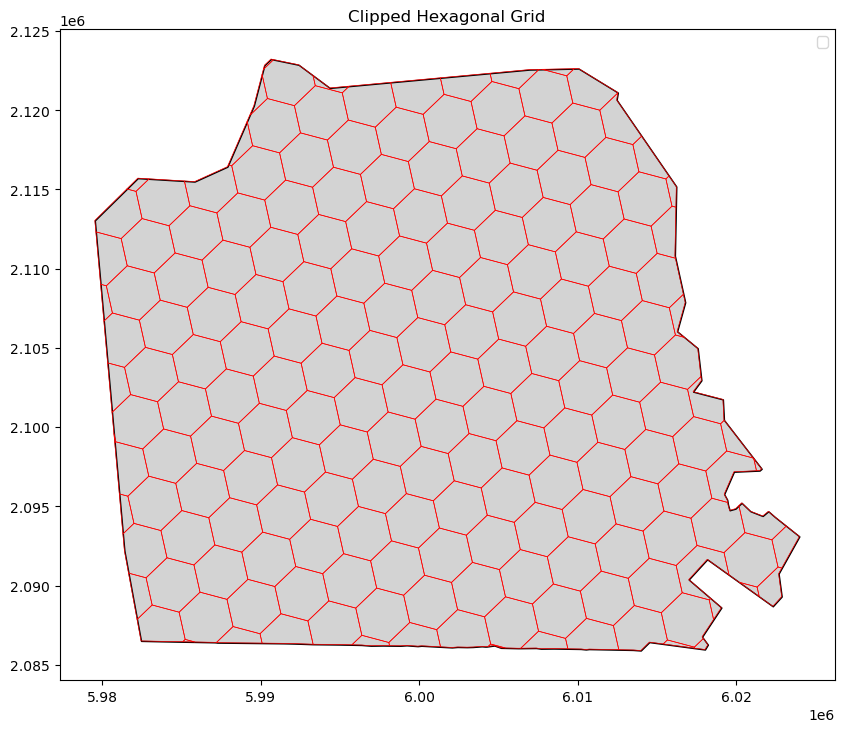

In [7]:
clipped_hex_grid = gpd.clip(hex_grid, sf_unified_gdf)

clipped_hex_grid['area'] = clipped_hex_grid.geometry.area

num_hexagons = len(clipped_hex_grid)
print(f"Number of clipped hexagons: {num_hexagons}")

fig, ax = plt.subplots(figsize=(10, 10))
sf_unified_gdf.plot(ax=ax, color='lightgray', edgecolor='black', label='San Francisco Boundary')
clipped_hex_grid.plot(ax=ax, color='none', edgecolor='red', linewidth=0.5, label='Clipped Hex Grid')
ax.set_title("Clipped Hexagonal Grid")
ax.legend()
plt.show()

### Making Hex/Month Grid

In [8]:
from itertools import product

# List of hex IDs (from clipped_hex_grid)
hex_ids = clipped_hex_grid['h3_index'].unique()

# Generate a range of months (January 2023 to October 2024)
months = pd.date_range(start="2023-01-01", end="2024-10-31", freq='MS').strftime("%Y-%m").tolist()

# Create a baseline DataFrame with all hexes and months
hex_month_grid = pd.DataFrame(list(product(hex_ids, months)), columns=['hex_id', 'month_year'])

# Merge the 'area' column from clipped_hex_grid into hex_month_grid
hex_month_grid = hex_month_grid.merge(
    clipped_hex_grid[['h3_index', 'geometry', 'area']],  # Selecting only the relevant columns
    left_on='hex_id',  # Left DataFrame column
    right_on='h3_index',  # Right DataFrame column
    how='left'  # Left join to keep all rows from hex_month_grid
)

# Drop the 'h3_index' column from hex_month_grid
hex_month_grid = hex_month_grid.drop(columns=['h3_index'])

# Verify the changes
print(hex_month_grid.head())

            hex_id month_year  \
0  8828309555fffff    2023-01   
1  8828309555fffff    2023-02   
2  8828309555fffff    2023-03   
3  8828309555fffff    2023-04   
4  8828309555fffff    2023-05   

                                            geometry           area  
0  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
1  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
2  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
3  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
4  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  


In [9]:
# List of hex IDs (from clipped_hex_grid)
hex_ids = clipped_hex_grid['h3_index'].unique()

# Generate a range of months (January 2023 to October 2024)
months = pd.date_range(start="2023-01-01", end="2024-10-31", freq='MS').strftime("%Y-%m").tolist()

# Create a baseline DataFrame with all hexes and months
hex_month_grid = pd.DataFrame(list(product(hex_ids, months)), columns=['hex_id', 'month_year'])

# Merge the 'area' column from clipped_hex_grid into hex_month_grid
hex_month_grid = hex_month_grid.merge(
    clipped_hex_grid[['h3_index', 'geometry', 'area']],  # Selecting only the relevant columns
    left_on='hex_id',  # Left DataFrame column
    right_on='h3_index',  # Right DataFrame column
    how='left'  # Left join to keep all rows from hex_month_grid
)

# Drop the 'h3_index' column from hex_month_grid
hex_month_grid = hex_month_grid.drop(columns=['h3_index'])

# Now, convert hex_month_grid into a GeoDataFrame
hex_month_grid_gdf = gpd.GeoDataFrame(hex_month_grid, geometry='geometry')

# Set the CRS (replace with the CRS of your original data, if known)
# If clipped_hex_grid has a CRS, you can directly copy it. For example:
hex_month_grid_gdf.set_crs(clipped_hex_grid.crs, allow_override=True, inplace=True)

# Verify the GeoDataFrame
print(hex_month_grid_gdf.head())

            hex_id month_year  \
0  8828309555fffff    2023-01   
1  8828309555fffff    2023-02   
2  8828309555fffff    2023-03   
3  8828309555fffff    2023-04   
4  8828309555fffff    2023-05   

                                            geometry           area  
0  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
1  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
2  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
3  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
4  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  


### Bay Wheels docking stations (static)

In [10]:
# Import and clean Bay Wheels docking stations
# Load docking stations as a GeoDataFrame
docking_stations = gpd.read_file("data/Bay_Area_Bike_Share_Stations_20241204.csv")

# Create a geometry column from Station Latitude and Station Longitude
docking_stations['geometry'] = docking_stations.apply(
    lambda row: Point(row['Station Longitude'], row['Station Latitude']),
    axis=1
)

# Set the GeoDataFrame's CRS to match the coordinate reference system (WGS 84, EPSG:4326)
docking_stations_gpd = gpd.GeoDataFrame(docking_stations, geometry='geometry', crs="EPSG:4326")

# Reproject stations to match hex grid CRS (EPSG:2227)
docking_stations_gpd = docking_stations_gpd.to_crs("EPSG:2227")

# Filter docking stations within San Francisco using spatial intersection
docking_stations_within_sf = gpd.sjoin(
    docking_stations_gpd, 
    sf_unified_gdf, 
    predicate='within', 
    how='inner'
)

# Perform a spatial join to associate each docking station with the corresponding hexagon
docking_stations_in_hex = gpd.sjoin(
    docking_stations_within_sf, 
    clipped_hex_grid, 
    how='inner', 
    predicate='within', 
    lsuffix='_left',  # Adding custom suffix to left dataframe
    rsuffix='_right'  # Adding custom suffix to right dataframe
)

# Now you can count the number of docking stations per hexagon
docking_station_count = docking_stations_in_hex.groupby('h3_index').size().reset_index(name='docking_station_count')

# Check if the merge was successful
print(docking_station_count.columns)  # Ensure this includes 'h3_index' and 'docking_station_count'
print(clipped_hex_grid.columns)  # Verify the column names in the merged DataFrame


# Calculate the number of stations per hexagon and store in a new DataFrame
docking_station_count = docking_stations_in_hex.groupby('h3_index').size().reset_index(name='docking_station_count')

# Check if the merge was successful
print(docking_station_count.columns)  # Ensure this includes 'h3_index' and 'docking_station_count'
print(clipped_hex_grid.columns)  # Verify the column names in the merged DataFrame

# Merge the counts back into the hex grid
clipped_hex_grid = clipped_hex_grid.merge(docking_station_count, on='h3_index', how='left')

# Verify column presence after merge
print(clipped_hex_grid.columns)

# Replace NaN with 0 for hexagons with no stations
clipped_hex_grid['docking_station_count'] = clipped_hex_grid['docking_station_count'].fillna(0)

Index(['h3_index', 'docking_station_count'], dtype='object')
Index(['h3_index', 'geometry', 'area'], dtype='object')
Index(['h3_index', 'docking_station_count'], dtype='object')
Index(['h3_index', 'geometry', 'area'], dtype='object')
Index(['h3_index', 'geometry', 'area', 'docking_station_count'], dtype='object')


/var/folders/6b/33d16tr12453_x5yvp1kg99c0000gn/T/ipykernel_29373/603996422.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


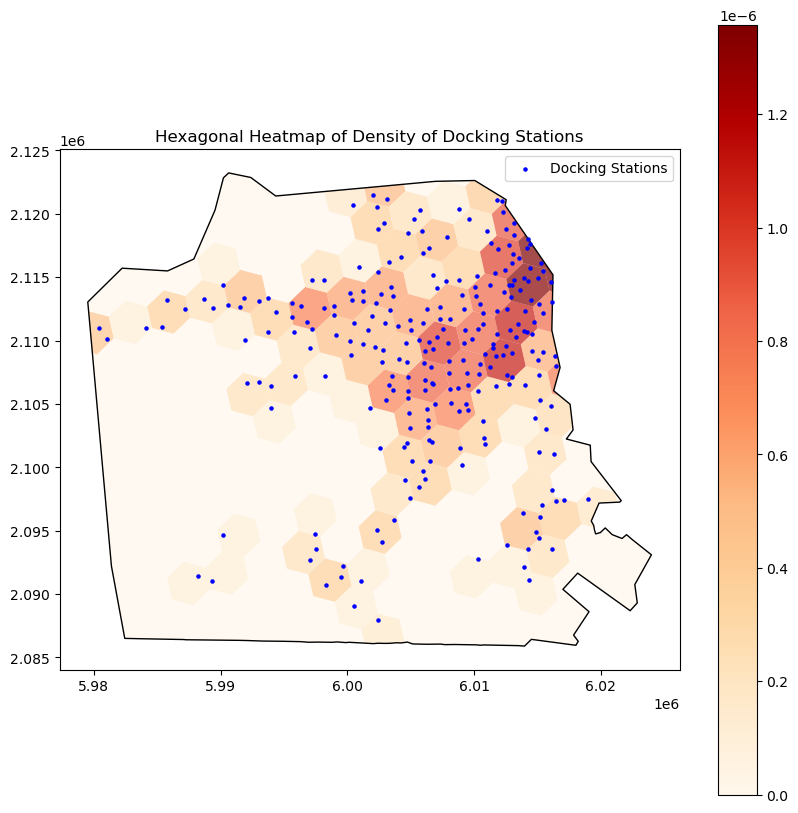

In [11]:
# Calculate docking station density (stations per unit area)
clipped_hex_grid['docking_station_count_density'] = clipped_hex_grid['docking_station_count'] / clipped_hex_grid['area']

# Plot the hex grid heatmap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the hexagonal heatmap
clipped_hex_grid.plot(column='docking_station_count_density', ax=ax, cmap='OrRd', legend=True, alpha=0.7)

# Plot the San Francisco boundary
sf_unified_gdf.plot(ax=ax, color='none', edgecolor='black', label='SF Boundary')

# Plot the docking stations
docking_stations_within_sf.plot(ax=ax, color='blue', markersize=5, label='Docking Stations')

# Add title and legend
plt.title('Hexagonal Heatmap of Density of Docking Stations')
ax.legend()
plt.show()

In [12]:
print(clipped_hex_grid.head(50))
print(hex_month_grid.head())

           h3_index                                           geometry  \
0   8828309555fffff  POLYGON ((5996380.891 2086860.332, 5998083.382...   
1   882830942dfffff  POLYGON ((5988252.579 2087411.663, 5989954.716...   
2   8828309553fffff  POLYGON ((5989954.716 2086957.954, 5991273.900...   
3   8828309557fffff  POLYGON ((5992976.150 2087767.793, 5994295.368...   
4   8828309425fffff  POLYGON ((5988252.579 2087411.663, 5987869.641...   
5   8828309519fffff  POLYGON ((5991273.900 2088221.493, 5990890.883...   
6   882830951dfffff  POLYGON ((5994295.368 2089031.363, 5993912.274...   
7   882830951bfffff  POLYGON ((5989188.761 2090392.312, 5988805.810...   
8   8828309429fffff  POLYGON ((5985231.408 2086601.874, 5985841.955...   
9   882830942bfffff  POLYGON ((5983146.652 2088772.664, 5984848.547...   
10  8828309421fffff  POLYGON ((5985231.408 2086601.874, 5984848.547...   
11  882830943dfffff  POLYGON ((5982763.855 2090489.680, 5983146.652...   
12  8828309423fffff  POLYGON ((5983146

### Bike Parking Data (Dynamic)

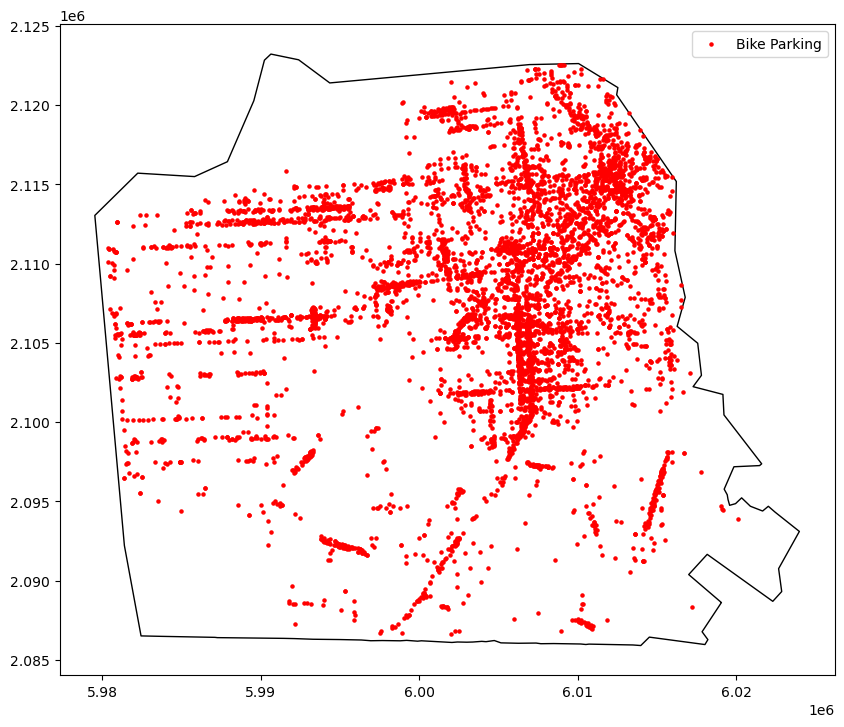

In [13]:
# import and clean bike parking
bike_parking = gpd.read_file("data/Bicycle_Parking_Racks.csv")

# Remove rows with empty "shape" column
bike_parking = bike_parking.dropna(subset=['shape'])

# Check for rows with invalid or empty WKT
invalid_wkt = bike_parking[~bike_parking['shape'].str.startswith("POINT")]

# Remove invalid or empty WKT rows
bike_parking = bike_parking[bike_parking['shape'].str.startswith("POINT")]

# Convert "shape" column into geometries and set CRS
bike_parking['geometry'] = gpd.GeoSeries.from_wkt(bike_parking['shape'])  # Convert WKT to geometries
bike_parking = gpd.GeoDataFrame(bike_parking, geometry='geometry', crs="EPSG:4326")

# Reproject to match sf_unified_gdf CRS
bike_parking = bike_parking.to_crs(sf_unified_gdf.crs)

# Filter points within the study area
bike_parking_within_sf = gpd.sjoin(bike_parking, sf_unified_gdf, predicate='within', how='inner')

# Check results visually (optional)
ax = sf_unified_gdf.plot(color='none', edgecolor='black', figsize=(10, 10))
bike_parking_within_sf.plot(ax=ax, color='red', markersize=5, label='Bike Parking')
plt.legend()
plt.show()

Removing 68 with invalid point data. Visually, the remaining points look correct.

In [14]:
def format_installation_date(row):
    # Convert INSTALL_YR to integer, handling cases where it's a string
    try:
        year = int(row['INSTALL_YR'])
    except ValueError:
        # If it's not a valid number (e.g. empty or invalid data), handle it gracefully
        year = 0
    
    # Apply the logic based on the value of INSTALL_YR
    if pd.isna(year) or year <= 2022:
        return "2022-12"  # Default to December 2022
    
    # Handle missing or empty months in INSTALL_MO
    try:
        # Ensure INSTALL_MO is a valid number or default to 12 (December)
        month = int(row['INSTALL_MO']) if pd.notna(row['INSTALL_MO']) and row['INSTALL_MO'] != '' else 12
    except ValueError:
        month = 12  # Default to December if the month is invalid (e.g., empty string or invalid number)

        # Print out problematic entries where the month is incorrect
        if year > 2022:
            print(f"Problematic entry: Year: {year}, Month: {row['INSTALL_MO']}") 
    
    # Format and return the installation date in "YYYY-MM" format
    return f"{year:04d}-{month:02d}"

# Apply the function
bike_parking_within_sf['installation_month'] = bike_parking_within_sf.apply(format_installation_date, axis=1)

In [15]:
# Perform the spatial join with custom suffixes to avoid name conflicts
bike_parking_with_hex = gpd.sjoin(
    bike_parking_within_sf,
    clipped_hex_grid,
    predicate='within',
    how='inner',
    lsuffix='_bp',  # Suffix for bike parking dataframe
    rsuffix='_hex'  # Suffix for hex grid dataframe
)

# Now proceed with your analysis


In [16]:
print(bike_parking_with_hex.head())

  OBJECTID              ADDRESS                   LOCATION          STREET  \
0    14108      342 30th Street                                30th Street   
1    12183        Belden Street               Belden Place            BUSH   
2    20813  1984 Mission Street                  H&R block  Mission Street   
3    11638       2762 FOLSOM ST              Inglesia Zion          FOLSOM   
4    12367       51 HAVELOCK ST  Balboa Park Swimming Pool        HAVELOCK   

  PLACEMENT RACKS SPACES GLOBALID INSTALL_YR INSTALL_MO  ...  \
0  SIDEWALK     4      8                2021          1  ...   
1  SIDEWALK     2      4                2017          1  ...   
2  SIDEWALK     1      2                2023         11  ...   
3  SIDEWALK     2      4                2011          3  ...   
4  SIDEWALK     2      4                2011          1  ...   

  Central Market/Tenderloin Boundary Polygon - Updated 2 Neighborhoods  \
0                                                                   84  

In [17]:
# Step 1: Create the full grid of hex_id_bp and month_year_bp (covering from 2022-12 to the latest month)
start_date = '2022-12'
end_date = '2024-12'
months = pd.date_range(start=start_date, end=end_date, freq='MS').strftime('%Y-%m')

# We need to create a list of all combinations of hex_id_bp and all months
hex_month_grid_bp = pd.DataFrame(list(product(hex_ids, months)), columns=['hex_id_bp', 'month_year_bp'])

# Step 2: Group by 'h3_index' (hex ID) and 'installation_month', and count the bike parking stations
bike_parking_count = bike_parking_with_hex.groupby(['h3_index', 'installation_month']).size().reset_index(name='bicycle_parking_count')

# Step 3: Rename columns for clarity
bike_parking_count = bike_parking_count.rename(columns={'h3_index': 'hex_id_bp', 'installation_month': 'month_year_bp'})

# Step 4: Sort by 'hex_id_bp' and 'month_year_bp' to ensure the cumulative sum is calculated in order
bike_parking_count = bike_parking_count.sort_values(by=['hex_id_bp', 'month_year_bp'])

# Step 5: Calculate the cumulative sum of bike parking stations by 'hex_id_bp'
bike_parking_count['cumulative_bicycle_parking_count'] = bike_parking_count.groupby('hex_id_bp')['bicycle_parking_count'].cumsum()

# Step 6: Merge with the baseline hex_month_grid, so that we have every month for each hex ID
hex_month_grid_with_bike_parking = hex_month_grid_bp.merge(
    bike_parking_count[['hex_id_bp', 'month_year_bp', 'cumulative_bicycle_parking_count']],
    on=['hex_id_bp', 'month_year_bp'],
    how='left'
)

# Step 7: Forward-fill missing months for each hex_id_bp
# First, make sure all NaNs are properly forward-filled within each hex_id_bp group
hex_month_grid_with_bike_parking['cumulative_bicycle_parking_count'] = hex_month_grid_with_bike_parking.groupby('hex_id_bp')['cumulative_bicycle_parking_count'].ffill()

# Step 8: Fill the first month (2022-12) with 0s where necessary, as they should not have NaN
hex_month_grid_with_bike_parking['cumulative_bicycle_parking_count'] = hex_month_grid_with_bike_parking.groupby('hex_id_bp')['cumulative_bicycle_parking_count'].transform(lambda x: x.fillna(0))

pd.set_option('display.max_rows', 500)

# Display the DataFrame to see the first 50 rows
print(hex_month_grid_with_bike_parking.head(50))

          hex_id_bp month_year_bp  cumulative_bicycle_parking_count
0   8828309555fffff       2022-12                               0.0
1   8828309555fffff       2023-01                               0.0
2   8828309555fffff       2023-02                               0.0
3   8828309555fffff       2023-03                               0.0
4   8828309555fffff       2023-04                               0.0
5   8828309555fffff       2023-05                               0.0
6   8828309555fffff       2023-06                               0.0
7   8828309555fffff       2023-07                               0.0
8   8828309555fffff       2023-08                               0.0
9   8828309555fffff       2023-09                               0.0
10  8828309555fffff       2023-10                               0.0
11  8828309555fffff       2023-11                               0.0
12  8828309555fffff       2023-12                               0.0
13  8828309555fffff       2024-01               

In [18]:
print(hex_month_grid_with_bike_parking.head())
print(hex_month_grid_gdf.head())

         hex_id_bp month_year_bp  cumulative_bicycle_parking_count
0  8828309555fffff       2022-12                               0.0
1  8828309555fffff       2023-01                               0.0
2  8828309555fffff       2023-02                               0.0
3  8828309555fffff       2023-03                               0.0
4  8828309555fffff       2023-04                               0.0
            hex_id month_year  \
0  8828309555fffff    2023-01   
1  8828309555fffff    2023-02   
2  8828309555fffff    2023-03   
3  8828309555fffff    2023-04   
4  8828309555fffff    2023-05   

                                            geometry           area  
0  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
1  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
2  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
3  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052  
4  POLYGON ((5996380.891 2086860.332, 5998083.382

In [19]:
# Merge with only necessary columns
hex_month_grid_gdf = hex_month_grid_gdf.merge(
    hex_month_grid_with_bike_parking[['hex_id_bp', 'month_year_bp', 'cumulative_bicycle_parking_count']], 
    left_on=['hex_id', 'month_year'], 
    right_on=['hex_id_bp', 'month_year_bp'], 
    how='left'
)

In [20]:
hex_month_grid_gdf = hex_month_grid_gdf.drop(columns=['hex_id_bp', 'month_year_bp'])




In [21]:

# Add bicycle_parking_density by dividing cumulative_bicycle_parking_count by area
hex_month_grid_gdf['bicycle_parking_density'] = hex_month_grid_gdf['cumulative_bicycle_parking_count'] / hex_month_grid_gdf['area']


hex_month_grid_gdf.head()

hex_id month_year  \
0  8828309555fffff    2023-01   
1  8828309555fffff    2023-02   
2  8828309555fffff    2023-03   
3  8828309555fffff    2023-04   
4  8828309555fffff    2023-05   

                                            geometry           area  \
0  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
1  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
2  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
3  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
4  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   

   cumulative_bicycle_parking_count  bicycle_parking_density  
0                               0.0                      0.0  
1                               0.0                      0.0  
2                               0.0                      0.0  
3                               0.0                      0.0  
4                               0.0                      0.0

In [22]:
hex_month_grid_gdf

hex_id month_year  \
0     8828309555fffff    2023-01   
1     8828309555fffff    2023-02   
2     8828309555fffff    2023-03   
3     8828309555fffff    2023-04   
4     8828309555fffff    2023-05   
...               ...        ...   
4109  88283080ddfffff    2024-06   
4110  88283080ddfffff    2024-07   
4111  88283080ddfffff    2024-08   
4112  88283080ddfffff    2024-09   
4113  88283080ddfffff    2024-10   

                                               geometry           area  \
0     POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
1     POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
2     POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
3     POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
4     POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
...                                                 ...            ...   
4109  POLYGON ((6009313.573 2122170.147, 6007768.596...  446651.398402   
4110  POLYGON ((6009313.573 2122170.147, 6007768.596...  446651.398402   
4111  POLYGON ((6009313.573 2122170.147, 6007768.596...  446651.398402   
4112  POLYGON ((6009313.573 2122170.147, 6007768.596...  446651.398402   
4113  POLYGON ((6009313.573 2122170.147, 6007768.596...  446651.398402   

      cumulative_bicycle_parking_count  bicycle_parking_density  
0                                  0.0                 0.000000  
1                                  0.0                 0.000000  
2                                  0.0                 0.000000  
3                                  0.0                 0.000000  
4                                  0.0                 0.000000  
...                                ...                      ...  
4109                               5.0                 0.000011  
4110                               5.0                 0.000011  
4111                               5.0                 0.000011  
4112                               5.0                 0.000011  
4113                               5.0                 0.000011  

[4114 rows x 6 columns]

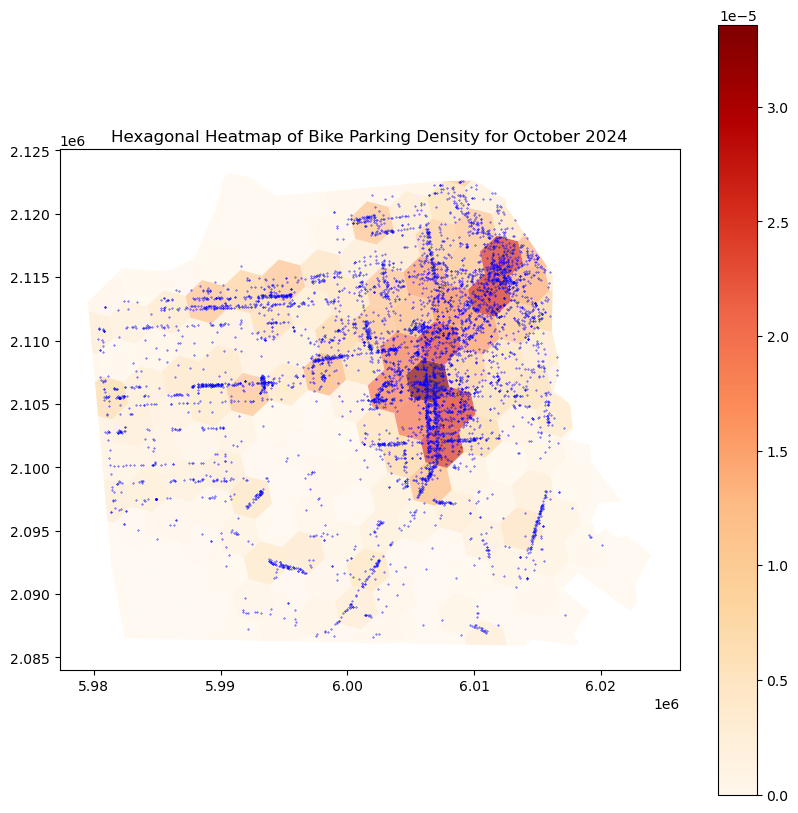

In [23]:
# Step 1: Filter for the data for October 2024
october_2024_data = hex_month_grid_gdf[hex_month_grid_gdf['month_year'] == '2024-10']

# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Step 4: Plot the hexagonal heatmap based on bike parking density
october_2024_data.plot(column='bicycle_parking_density', ax=ax, cmap='OrRd', legend=True, alpha=0.7)

# Step 6: Plot the bike parking stations (if you want to show them)
# Uncomment and replace with your actual GeoDataFrame of bike parking points
bike_parking_within_sf.plot(ax=ax, color='blue', markersize=.1, label='Bike Parking')

# Step 7: Add title and legend
plt.title('Hexagonal Heatmap of Bike Parking Density for October 2024')

# Step 8: Show the plot
plt.show()

### Bike Lane Density (Dynamic)

In [24]:
# import and clean bike lanes
bike_lanes = gpd.read_file("data/MTA_Bike_Network_Linear_Features.csv")

# Apply the function
bike_lanes['installation_month_bl'] = bike_lanes.apply(format_installation_date, axis=1)

bike_lanes.head()

OBJECTID      CNN         STREETNAME            FROM_ST    TO_ST FACILITY_T  \
0     4614  3467000        CABRILLO ST      ARGUELLO BLVD   2ND AV   CLASS II   
1     4949  5120000  EL CAMINO DEL MAR       LINCOLN BLVD  25TH AV   CLASS II   
2      653  4185000         CLEMENT ST            35TH AV  36TH AV  CLASS III   
3     5060  1372000           25TH AVE  EL CAMINO DEL MAR  LAKE ST   CLASS II   
4      248  3475000        CABRILLO ST             9TH AV  10TH AV   CLASS II   

  DIRECT SURFACE_TR BARRIER NOTES  ... CONTRAFLOW GREENWAVE BIAP SM_SWEEPER  \
0     2W                           ...         NO        NO   NO         NO   
1     2W                           ...         NO        NO   NO         NO   
2     2W                           ...         NO        NO   NO         NO   
3     2W                           ...         NO        NO   NO         NO   
4     2W                           ...         NO        NO   NO         NO   

                                               shape RECOMMENDATION  \
0  LINESTRING (-122.458462902 37.775618427, -122....              1   
1  LINESTRING (-122.484146101 37.787664873, -122....              0   
2  LINESTRING (-122.495590624 37.781527261, -122....              1   
3  LINESTRING (-122.485283461 37.787611838, -122....              0   
4  LINESTRING (-122.467086295 37.775222829, -122....              1   

               data_as_of          data_loaded_at geometry  \
0  05/19/2023 01:12:06 PM  07/13/2024 10:07:45 AM     None   
1  05/19/2023 01:39:46 PM  07/13/2024 10:07:45 AM     None   
2  05/19/2023 01:12:02 PM  07/13/2024 10:07:45 AM     None   
3  05/19/2023 01:39:50 PM  07/13/2024 10:07:45 AM     None   
4  05/19/2023 01:12:02 PM  07/13/2024 10:07:45 AM     None   

  installation_month_bl  
0               2022-12  
1               2022-12  
2               2022-12  
3               2022-12  
4               2022-12  

[5 rows x 36 columns]

In [25]:
from shapely import wkt
from shapely import LineString

# Step 1: Filter out missing or empty WKT strings
bike_lanes = bike_lanes[bike_lanes['shape'].notna() & (bike_lanes['shape'] != '')]

# Step 2: Convert WKT strings to Shapely geometries
bike_lanes['geometry'] = bike_lanes['shape'].apply(wkt.loads)

# Step 3: Create a GeoDataFrame
bike_lanes = gpd.GeoDataFrame(bike_lanes, geometry='geometry', crs="EPSG:4326")

# Step 4: Reproject to match the CRS of `sf_unified_gdf`
bike_lanes = bike_lanes.to_crs(sf_unified_gdf.crs)

# Verify the result
print(bike_lanes.head())

  OBJECTID      CNN         STREETNAME            FROM_ST    TO_ST FACILITY_T  \
0     4614  3467000        CABRILLO ST      ARGUELLO BLVD   2ND AV   CLASS II   
1     4949  5120000  EL CAMINO DEL MAR       LINCOLN BLVD  25TH AV   CLASS II   
2      653  4185000         CLEMENT ST            35TH AV  36TH AV  CLASS III   
3     5060  1372000           25TH AVE  EL CAMINO DEL MAR  LAKE ST   CLASS II   
4      248  3475000        CABRILLO ST             9TH AV  10TH AV   CLASS II   

  DIRECT SURFACE_TR BARRIER NOTES  ... CONTRAFLOW GREENWAVE BIAP SM_SWEEPER  \
0     2W                           ...         NO        NO   NO         NO   
1     2W                           ...         NO        NO   NO         NO   
2     2W                           ...         NO        NO   NO         NO   
3     2W                           ...         NO        NO   NO         NO   
4     2W                           ...         NO        NO   NO         NO   

                                      

In [26]:
print(bike_lanes.columns)

Index(['OBJECTID', 'CNN', 'STREETNAME', 'FROM_ST', 'TO_ST', 'FACILITY_T',
       'DIRECT', 'SURFACE_TR', 'BARRIER', 'NOTES', 'DIR', 'DOUBLE', 'FY',
       'QTR', 'STREET_', 'LENGTH', 'NUMBER_', 'INSTALL_YR', 'INSTALL_MO',
       'UPDATE_YR', 'UPDATE_MO', 'GLOBALID', 'SYMBOLOGY', 'SHARROW',
       'BUFFERED', 'RAISED', 'CONTRAFLOW', 'GREENWAVE', 'BIAP', 'SM_SWEEPER',
       'shape', 'RECOMMENDATION', 'data_as_of', 'data_loaded_at', 'geometry',
       'installation_month_bl'],
      dtype='object')


In [27]:
# Check the CRS (Coordinate Reference System) of both GeoDataFrames before the join
print(f"Bike lanes CRS: {bike_lanes.crs}")
print(f"Clipped hex grid CRS: {clipped_hex_grid.crs}")

bike_lanes = bike_lanes.drop(columns=['CNN', 'STREETNAME', 'FROM_ST', 'TO_ST', 'FACILITY_T',
       'DIRECT', 'SURFACE_TR', 'BARRIER', 'NOTES', 'DIR', 'DOUBLE', 'FY',
       'QTR', 'STREET_', 'LENGTH', 'NUMBER_',
       'UPDATE_YR', 'UPDATE_MO', 'GLOBALID', 'SHARROW',
       'BUFFERED', 'RAISED', 'CONTRAFLOW', 'GREENWAVE', 'BIAP', 'SM_SWEEPER',
       'RECOMMENDATION', 'data_as_of', 'data_loaded_at'])

# Now perform the spatial join
bike_lanes_with_hex = gpd.sjoin(
    bike_lanes, 
    clipped_hex_grid, 
    how='inner', 
    predicate='intersects', 
    lsuffix='_bike_lane',  # Suffix for bike lane geometry
    rsuffix='_hex'         # Suffix for hexagon geometry
)

# Check the columns to verify that both geometries are present
print(bike_lanes_with_hex.columns)

Bike lanes CRS: EPSG:2227
Clipped hex grid CRS: EPSG:2227
Index(['OBJECTID', 'INSTALL_YR', 'INSTALL_MO', 'SYMBOLOGY', 'shape',
       'geometry', 'installation_month_bl', 'index__hex', 'h3_index', 'area',
       'docking_station_count', 'docking_station_count_density'],
      dtype='object')


In [28]:
bike_lanes_with_hex = bike_lanes_with_hex.drop(columns=['INSTALL_YR', 'index__hex', 'shape', 'INSTALL_MO', 'docking_station_count', 'docking_station_count_density'])

In [29]:

# Verify the changes
print(bike_lanes_with_hex.head())

  OBJECTID   SYMBOLOGY                                           geometry  \
0     4614   BIKE LANE  LINESTRING (5995675.294 2110804.226, 5995349.6...   
1     4949   BIKE LANE  LINESTRING (5988346.994 2115345.952, 5988017.9...   
2      653  BIKE ROUTE  LINESTRING (5984992.958 2113181.953, 5984683.6...   
2      653  BIKE ROUTE  LINESTRING (5984992.958 2113181.953, 5984683.6...   
3     5060   BIKE LANE  LINESTRING (5988017.993 2115333.616, 5988042.7...   

  installation_month_bl         h3_index          area  
0               2022-12  88283095a5fffff  8.243507e+06  
1               2022-12  88283095b7fffff  6.333361e+06  
2               2022-12  88283095b1fffff  8.239998e+06  
2               2022-12  88283095b3fffff  7.559660e+06  
3               2022-12  88283095b7fffff  6.333361e+06  


In [30]:
# Ensure 'h3_index' is the key for merging or lookup
# First, create a lookup dictionary from clipped_hex_grid based on 'h3_index'
hex_lookup = clipped_hex_grid.set_index('h3_index')['geometry'].to_dict()

# Add the geometry to bike_lanes_with_hex based on matching 'h3_index'
bike_lanes_with_hex['hex_geometry'] = bike_lanes_with_hex['h3_index'].map(hex_lookup)

Note- only 22 features were installed 2023-02 and later.

In [31]:
# Perform intersection with hexagons
bike_lanes_with_hex['clipped_geometry'] = bike_lanes_with_hex.apply(
    lambda row: row['geometry'].intersection(row['hex_geometry']), axis=1
)

In [32]:
bike_lanes_with_hex['line_length'] = bike_lanes_with_hex['clipped_geometry'].length

In [33]:
bike_lanes_with_hex.head()

OBJECTID   SYMBOLOGY                                           geometry  \
0     4614   BIKE LANE  LINESTRING (5995675.294 2110804.226, 5995349.6...   
1     4949   BIKE LANE  LINESTRING (5988346.994 2115345.952, 5988017.9...   
2      653  BIKE ROUTE  LINESTRING (5984992.958 2113181.953, 5984683.6...   
2      653  BIKE ROUTE  LINESTRING (5984992.958 2113181.953, 5984683.6...   
3     5060   BIKE LANE  LINESTRING (5988017.993 2115333.616, 5988042.7...   

  installation_month_bl         h3_index          area  \
0               2022-12  88283095a5fffff  8.243507e+06   
1               2022-12  88283095b7fffff  6.333361e+06   
2               2022-12  88283095b1fffff  8.239998e+06   
2               2022-12  88283095b3fffff  7.559660e+06   
3               2022-12  88283095b7fffff  6.333361e+06   

                                        hex_geometry  \
0  POLYGON ((5994804.973739105 2108273.422228804,...   
1  POLYGON ((5988167.891115938 2116497.321198883,...   
2  POLYGON ((5984594.459499263 2110991.845003701,...   
2  POLYGON ((5985530.43477339 2113971.075313069, ...   
3  POLYGON ((5988167.891115938 2116497.321198883,...   

                                    clipped_geometry  line_length  
0  LINESTRING (5995675.294 2110804.226, 5995349.6...   325.868426  
1  LINESTRING (5988346.994 2115345.952, 5988017.9...   329.231590  
2  LINESTRING (5984992.958 2113181.953, 5984694.9...   298.261805  
2  LINESTRING (5984694.905 2113170.777, 5984683.6...    11.284901  
3  LINESTRING (5988017.993 2115333.616, 5988042.7...   680.513501

In [34]:
# Group by hex index, installation month, and bike lane type (SYMBOLOGY), summing up line lengths
monthly_lane_totals = bike_lanes_with_hex.groupby(
    ['h3_index', 'installation_month_bl', 'SYMBOLOGY'], as_index=False
)['line_length'].sum()

In [35]:
monthly_lane_totals.head()

h3_index installation_month_bl          SYMBOLOGY   line_length
0  88283080c9fffff               2022-12          BIKE LANE  14678.470728
1  88283080c9fffff               2022-12          BIKE PATH   6106.342200
2  88283080c9fffff               2022-12         BIKE ROUTE   3908.939226
3  88283080c9fffff               2022-12  SEPARATED BIKEWAY   2212.619762
4  88283080c9fffff               2023-01  SEPARATED BIKEWAY   2194.005566

In [36]:
# Generate the full timeline of months
timeline = pd.date_range(start="2022-12", end="2024-10", freq="MS").strftime("%Y-%m").tolist()

# Get unique h3_indices and SYMBOLOGY types
unique_h3_indices = monthly_lane_totals['h3_index'].unique()
unique_symbology = monthly_lane_totals['SYMBOLOGY'].unique()

# Create a complete grid of h3_index, month, and SYMBOLOGY
full_grid = pd.DataFrame(list(product(unique_h3_indices, timeline, unique_symbology)), 
                         columns=['h3_index', 'installation_month_bl', 'SYMBOLOGY'])

In [37]:
# Ensure month format is consistent
monthly_lane_totals['installation_month_bl'] = pd.to_datetime(monthly_lane_totals['installation_month_bl']).dt.strftime("%Y-%m")

# Merge full grid with the existing data
merged_data = full_grid.merge(monthly_lane_totals, 
                              on=['h3_index', 'installation_month_bl', 'SYMBOLOGY'], 
                              how='left').fillna(0)  # Fill missing line_length with 0

In [38]:
# Ensure correct sorting by h3_index, SYMBOLOGY, and month
merged_data = merged_data.sort_values(by=['h3_index', 'SYMBOLOGY', 'installation_month_bl'])

# Calculate cumulative line length
merged_data['cumulative_line_length'] = merged_data.groupby(['h3_index', 'SYMBOLOGY'])['line_length'].cumsum()

In [39]:
# Pivot to create one column for each SYMBOLOGY
pivoted_data = merged_data.pivot_table(
    index=['h3_index', 'installation_month_bl'], 
    columns='SYMBOLOGY', 
    values='cumulative_line_length', 
    fill_value=0
).reset_index()

# Flatten the column index after pivoting
pivoted_data.columns.name = None  # Remove the multi-index

In [40]:
pivoted_data.head()

h3_index installation_month_bl     BIKE LANE  BIKE PATH  \
0  88283080c9fffff               2022-12  14678.470728  6106.3422   
1  88283080c9fffff               2023-01  14678.470728  6106.3422   
2  88283080c9fffff               2023-02  14678.470728  6106.3422   
3  88283080c9fffff               2023-03  14678.470728  6106.3422   
4  88283080c9fffff               2023-04  14678.470728  6106.3422   

    BIKE ROUTE  NEIGHBORWAY  SEPARATED BIKEWAY  
0  3908.939226          0.0        2212.619762  
1  3908.939226          0.0        4406.625327  
2  3908.939226          0.0        4406.625327  
3  3908.939226          0.0        4406.625327  
4  3908.939226          0.0        4406.625327

In [41]:
# Merge the data
merged_data_bl_bp = hex_month_grid_gdf.merge(
    pivoted_data,
    left_on=['hex_id', 'month_year'],
    right_on=['h3_index', 'installation_month_bl'],
    how='left'
).fillna(0)  # Fill missing bike lane data with 0

In [42]:
# Calculate densities for each SYMBOLOGY
symbologies = ['BIKE LANE', 'BIKE PATH', 'BIKE ROUTE', 'NEIGHBORWAY', 'SEPARATED BIKEWAY']
for symbology in symbologies:
    merged_data_bl_bp[f'{symbology}_density'] = merged_data_bl_bp[symbology] / merged_data_bl_bp['area']

# Calculate total density (sum of all SYMBOLOGY types)
merged_data_bl_bp['total_bike_lane_density'] = merged_data_bl_bp[[f'{s}_density' for s in symbologies]].sum(axis=1)

In [43]:
merged_data_bl_bp = merged_data_bl_bp.drop(columns=['h3_index', 'installation_month_bl'])

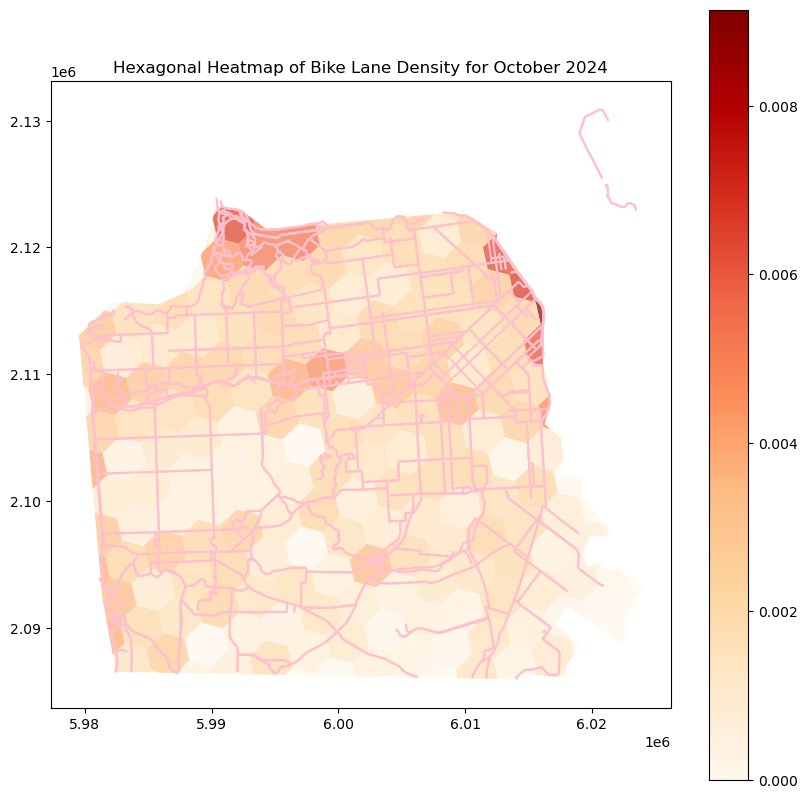

In [44]:
# Step 1: Filter for the data for October 2024
october_2024_data = merged_data_bl_bp[merged_data_bl_bp['month_year'] == '2024-10']

# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Step 4: Plot the hexagonal heatmap based on bike parking density
october_2024_data.plot(column='total_bike_lane_density', ax=ax, cmap='OrRd', legend=True, alpha=0.7)

# Step 6: Plot the bike parking stations (if you want to show them)
# Uncomment and replace with your actual GeoDataFrame of bike parking points
bike_lanes.plot(ax=ax, color='pink', markersize=.1, label='Bike Parking')

# Step 7: Add title and legend
plt.title('Hexagonal Heatmap of Bike Lane Density for October 2024')

# Step 8: Show the plot
plt.show()

Checked this against the map on SFMTA data website to make sure everything looked correct.

### Land Use

In [45]:
# import and clean land use
land_use = gpd.read_file("data/San_Francisco_Land_Use_-_2023_20241206.csv")

In [46]:
print(land_use.columns)

Index(['the_geom', 'mapblklot', 'restype', 'res', 'total', 'cie', 'med',
       'mips', 'retail', 'pdr', 'visitor', 'resunits', 'landuse', 'from_st',
       'to_st', 'street', 'st_type', 'geometry'],
      dtype='object')


In [47]:
land_use = land_use.drop(columns=['mapblklot', 'restype', 'res', 'total', 'cie', 'med',
       'mips', 'retail', 'pdr', 'visitor', 'resunits', 'from_st',
       'to_st', 'street', 'st_type', 'geometry'])

In [48]:
from shapely.wkt import loads
land_use['the_geom'] = land_use['the_geom'].apply(loads)
land_use = gpd.GeoDataFrame(land_use, geometry='the_geom')

In [49]:
land_use.head()

the_geom   landuse
0  MULTIPOLYGON (((-122.44480 37.77550, -122.4450...  RESIDENT
1  MULTIPOLYGON (((-122.44478 37.77543, -122.4450...  RESIDENT
2  MULTIPOLYGON (((-122.44477 37.77536, -122.4450...  RESIDENT
3  MULTIPOLYGON (((-122.44507 37.77512, -122.4450...    MIXRES
4  MULTIPOLYGON (((-122.44507 37.77512, -122.4451...  RESIDENT

In [50]:
# Assign the CRS to EPSG:4326
land_use = land_use.set_crs("EPSG:4326")

In [51]:
land_use.head()

the_geom   landuse
0  MULTIPOLYGON (((-122.44480 37.77550, -122.4450...  RESIDENT
1  MULTIPOLYGON (((-122.44478 37.77543, -122.4450...  RESIDENT
2  MULTIPOLYGON (((-122.44477 37.77536, -122.4450...  RESIDENT
3  MULTIPOLYGON (((-122.44507 37.77512, -122.4450...    MIXRES
4  MULTIPOLYGON (((-122.44507 37.77512, -122.4451...  RESIDENT

In [52]:
# transform crs of land_use
land_use = land_use.to_crs("EPSG:2227")

In [53]:
land_use.head()

the_geom   landuse
0  MULTIPOLYGON (((5999623.608 2110677.107, 59995...  RESIDENT
1  MULTIPOLYGON (((5999626.956 2110652.900, 59995...  RESIDENT
2  MULTIPOLYGON (((5999630.301 2110628.713, 59995...  RESIDENT
3  MULTIPOLYGON (((5999541.773 2110542.464, 59995...    MIXRES
4  MULTIPOLYGON (((5999541.773 2110542.464, 59995...  RESIDENT

In [54]:
# pull h3_index, geometry, area from clipped_hex_grid as land_use_hex and work with that
land_use_hex = clipped_hex_grid[['h3_index', 'geometry']]

In [55]:
land_use_hex.head()

h3_index                                           geometry
0  8828309555fffff  POLYGON ((5996380.891 2086860.332, 5998083.382...
1  882830942dfffff  POLYGON ((5988252.579 2087411.663, 5989954.716...
2  8828309553fffff  POLYGON ((5989954.716 2086957.954, 5991273.900...
3  8828309557fffff  POLYGON ((5992976.150 2087767.793, 5994295.368...
4  8828309425fffff  POLYGON ((5988252.579 2087411.663, 5987869.641...

In [56]:
print(land_use.crs, sf_unified_gdf.crs, land_use_hex.crs)

EPSG:2227 EPSG:2227 EPSG:2227


In [57]:
overlap_check = gpd.sjoin(land_use, sf_unified_gdf, how='inner', predicate='intersects')
print(f"Number of overlapping geometries: {len(overlap_check)}")
overlap_check = gpd.sjoin(land_use_hex, sf_unified_gdf, how='inner', predicate='intersects')
print(f"Number of overlapping geometries: {len(overlap_check)}")

Number of overlapping geometries: 153527
Number of overlapping geometries: 187


In [58]:
# sf_unified_gdf['area'] = sf_unified_gdf.geometry.area

# land_use_hex['hex_area'] = land_use_hex.geometry.area

# # Sum the areas to find the total area
# total_area_sf_unified = sf_unified_gdf['area'].sum()
# total_area_land_use_hex = land_use_hex['hex_area'].sum()

# # Print the total areas
# print(f"Total Area of sf_unified_gdf: {total_area_sf_unified}")
# print(f"Total Area of land_use_hex: {total_area_land_use_hex}")

In [59]:
# clip all geometry to study area
land_use_2 = gpd.overlay(land_use, sf_unified_gdf, how='intersection')

In [60]:
land_use_2_test = land_use_2[land_use_2['landuse'] == '']

Some are missing a landuse column- after mapping these appear to be mostly residential areas. Replaced.

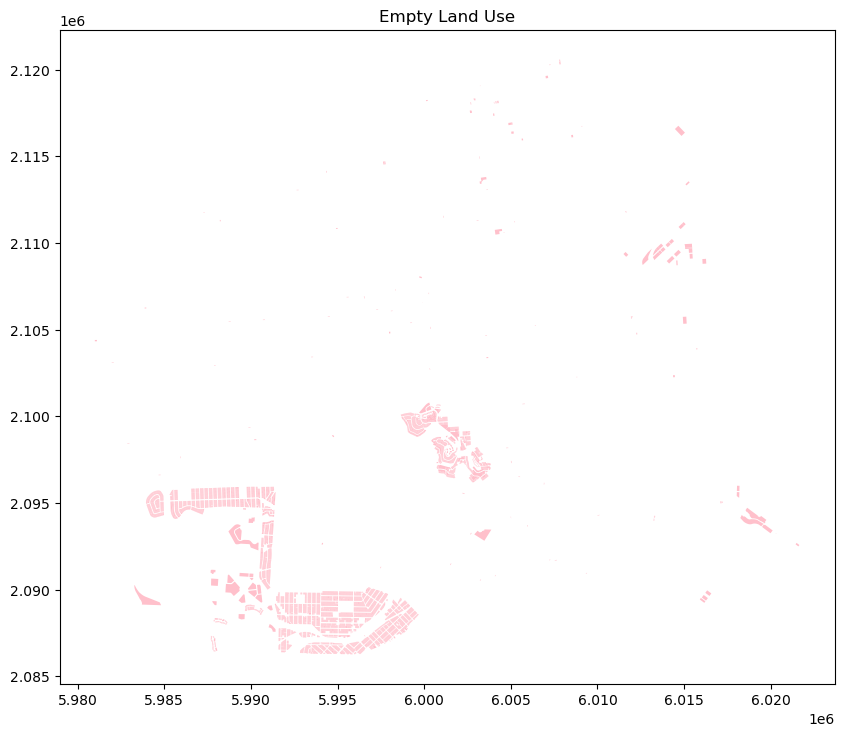

In [61]:
# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Step 6: Plot the bike parking stations (if you want to show them)
# Uncomment and replace with your actual GeoDataFrame of bike parking points
land_use_2_test.plot(ax=ax, color='pink', markersize=.1, label='Empty')

# Step 7: Add title and legend
plt.title('Empty Land Use')

# Step 8: Show the plot
plt.show()

In [62]:
land_use_2.loc[land_use_2['landuse'] == '', 'landuse'] = 'RESIDENT'

In [63]:
overlap_check = gpd.sjoin(land_use_2, sf_unified_gdf, how='inner', predicate='intersects')
print(f"Number of overlapping geometries: {len(overlap_check)}")

Number of overlapping geometries: 153527


In [64]:
print(land_use_2.head())
print(land_use_2.shape)

    landuse                                           geometry
0  RESIDENT  POLYGON ((5999543.499 2110665.978, 5999543.955...
1  RESIDENT  POLYGON ((5999543.154 2110641.257, 5999543.499...
2  RESIDENT  POLYGON ((5999542.809 2110616.558, 5999543.154...
3    MIXRES  POLYGON ((5999542.117 2110567.096, 5999636.999...
4  RESIDENT  POLYGON ((5999522.565 2110539.795, 5999505.488...
(153527, 2)


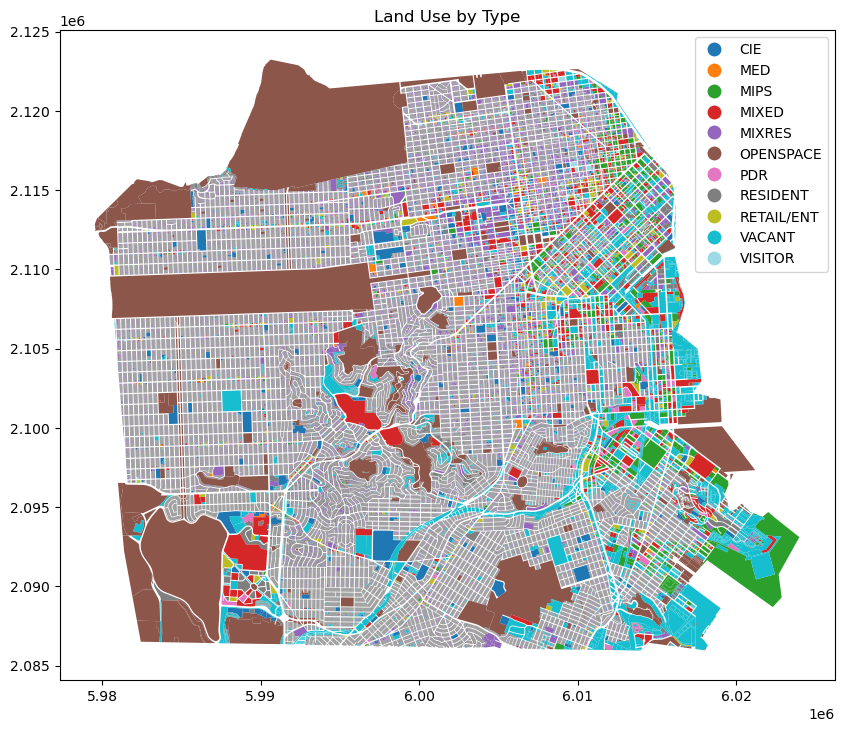

In [65]:
# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each type in the 'landuse' column with a different color
land_use_2.plot(ax=ax, column='landuse', legend=True, cmap='tab20')

# Step 7: Add title
plt.title('Land Use by Type')

# Step 8: Show the plot
plt.show()

In [66]:
total_area_land_use_2= land_use_2.copy()
total_area_land_use_2['row_area'] = total_area_land_use_2.geometry.area
total_area_land_use_2 = total_area_land_use_2['row_area'].sum()

print(f"Total Area of land use before hex: {total_area_land_use_2}")

Total Area of land use before hex: 949476829.4418181


In [67]:
land_use_overlay = gpd.overlay(land_use_2, land_use_hex, how='intersection')
print(land_use_overlay.head())
print(land_use_overlay.shape)
# Group by 'landuse' and calculate total area for each land use type

total_area_land_use_overlay= land_use_overlay.copy()
total_area_land_use_overlay['row_area'] = total_area_land_use_overlay.geometry.area
total_area_land_use_overlay_sum = total_area_land_use_overlay['row_area'].sum()

print(f"Total Area of land use after hex: {total_area_land_use_overlay_sum}")
sf_unified_gdf_area = sf_unified_gdf.copy()
land_cover_estimate = total_area_land_use_overlay_sum/sf_unified_gdf_area['geometry'].area
print(f"Percent covered by land use: {land_cover_estimate}")

    landuse         h3_index  \
0  RESIDENT  8828308299fffff   
1  RESIDENT  8828308299fffff   
2  RESIDENT  8828308299fffff   
3    MIXRES  8828308299fffff   
4  RESIDENT  8828308299fffff   

                                            geometry  
0  POLYGON ((5999543.955 2110698.601, 5999619.189...  
1  POLYGON ((5999543.499 2110665.978, 5999623.608...  
2  POLYGON ((5999543.154 2110641.257, 5999626.956...  
3  POLYGON ((5999636.999 2110580.278, 5999640.335...  
4  POLYGON ((5999505.488 2110660.697, 5999518.448...  
(162789, 3)
Total Area of land use after hex: 949476829.441815
Percent covered by land use: 0    0.743228
dtype: float64


In [68]:
land_use_overlay['row_area'] = land_use_overlay.geometry.area
land_use_overlay.head()

landuse         h3_index  \
0  RESIDENT  8828308299fffff   
1  RESIDENT  8828308299fffff   
2  RESIDENT  8828308299fffff   
3    MIXRES  8828308299fffff   
4  RESIDENT  8828308299fffff   

                                            geometry     row_area  
0  POLYGON ((5999543.955 2110698.601, 5999619.189...  2528.948184  
1  POLYGON ((5999543.499 2110665.978, 5999623.608...  2022.052054  
2  POLYGON ((5999543.154 2110641.257, 5999626.956...  2111.313361  
3  POLYGON ((5999636.999 2110580.278, 5999640.335...  2377.867525  
4  POLYGON ((5999505.488 2110660.697, 5999518.448...  3526.841891

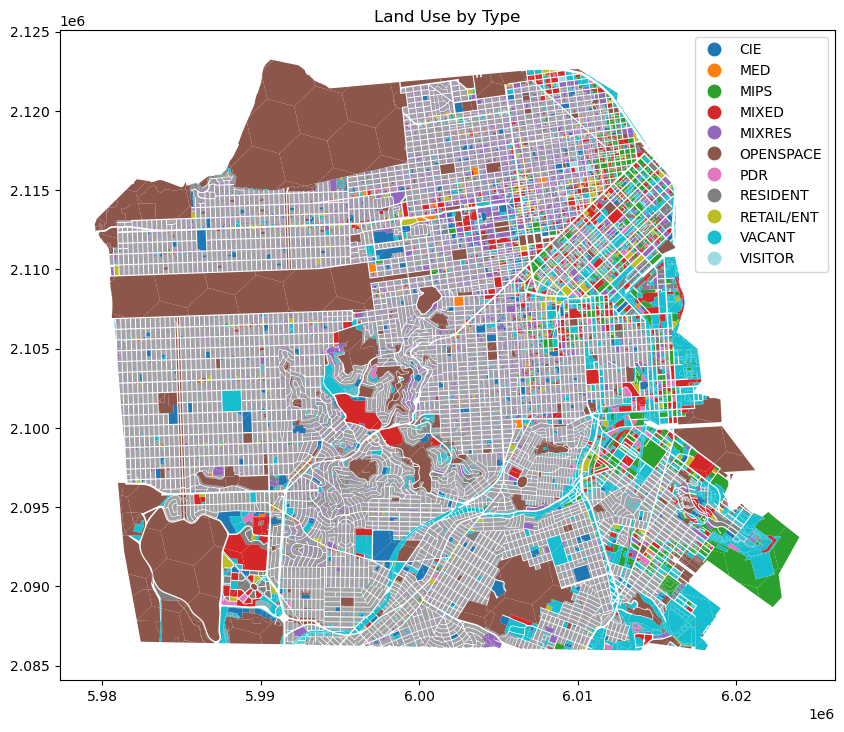

In [69]:
# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each type in the 'landuse' column with a different color
land_use_overlay.plot(ax=ax, column='landuse', legend=True, cmap='tab20')

# Step 7: Add title
plt.title('Land Use by Type')

# Step 8: Show the plot
plt.show()

In [70]:
# Drop the geometry column
land_use_overlay_no_geom = land_use_overlay.drop(columns=['geometry'])

# Group by h3_index and landuse, summing the row_area for each group
land_use_summary = land_use_overlay_no_geom.groupby(['h3_index', 'landuse'], as_index=False)['row_area'].sum()

# Rename the column to reflect the summed area
land_use_summary.rename(columns={'row_area': 'total_area'}, inplace=True)

# Display the result
print(land_use_summary)

             h3_index     landuse    total_area
0     88283080c9fffff         CIE  7.025688e+04
1     88283080c9fffff        MIPS  6.676461e+05
2     88283080c9fffff       MIXED  4.056889e+05
3     88283080c9fffff      MIXRES  4.197550e+05
4     88283080c9fffff   OPENSPACE  2.360131e+05
...               ...         ...           ...
1380  88283095edfffff      MIXRES  7.147986e+05
1381  88283095edfffff   OPENSPACE  1.124617e+06
1382  88283095edfffff    RESIDENT  3.781622e+06
1383  88283095edfffff  RETAIL/ENT  2.620180e+03
1384  88283095edfffff      VACANT  3.027101e+05

[1385 rows x 3 columns]


In [71]:
# Calculate the sum of the total_area column
total_area_sum = land_use_summary['total_area'].sum()

# Print the result
print(f"Total area sum: {total_area_sum}")

Total area sum: 949476829.4418149


In [72]:
# Pivot the table
land_use_wide = land_use_summary.pivot_table(
    index='h3_index', 
    columns='landuse', 
    values='total_area', 
    fill_value=0
).reset_index()

In [73]:
land_use_wide.head()

landuse         h3_index           CIE  MED          MIPS          MIXED  \
0        88283080c9fffff  70256.877157  0.0  6.676461e+05  405688.863012   
1        88283080cbfffff  74672.229564  0.0  2.167822e+05  204226.757126   
2        88283080d9fffff      0.000000  0.0  9.453143e+03   70282.860931   
3        88283080ddfffff      0.000000  0.0  0.000000e+00  102148.718942   
4        8828308201fffff      0.000000  0.0  1.716805e+06   66287.095634   

landuse         MIXRES     OPENSPACE           PDR       RESIDENT  \
0        419754.995996  2.360131e+05  20727.793402  183666.033628   
1        853949.330824  2.234023e+05  31375.686765  610365.047635   
2        132949.134274  1.522608e+06      0.000000    7977.952026   
3             0.000000  1.006790e+04      0.000000       0.000000   
4         20028.460013  9.927818e+04      0.000000    8402.948648   

landuse     RETAIL/ENT        VACANT  VISITOR  
0        143853.320980  5.926150e+05      0.0  
1         32913.367213  9.469865e+05      0.0  
2         77189.297542  2.439175e+05      0.0  
3         55355.178596  6.369083e+04      0.0  
4             0.000000  1.549002e+06      0.0

In [74]:
land_use_wide.columns = land_use_wide.columns.str.strip()

In [75]:
# Sum all columns except 'landuse' and 'h3_index'
total_sum = land_use_wide.drop(columns=['h3_index'])
total_sum = total_sum.sum(axis=1).sum()

# Print the result
print(f"Total summed area: {total_sum}")

Total summed area: 949476829.4418149


In [76]:
total_sum = clipped_hex_grid['area'].sum().sum()

# Print the result
print(f"Total summed area: {total_sum}")

Total summed area: 1277504106.6617107


Verifying the area is correct- units for 2227 are US feet

In [77]:
land_use_wide.columns

Index(['h3_index', 'CIE', 'MED', 'MIPS', 'MIXED', 'MIXRES', 'OPENSPACE', 'PDR',
       'RESIDENT', 'RETAIL/ENT', 'VACANT', 'VISITOR'],
      dtype='object', name='landuse')

In [78]:
land_use_wide.head()

landuse         h3_index           CIE  MED          MIPS          MIXED  \
0        88283080c9fffff  70256.877157  0.0  6.676461e+05  405688.863012   
1        88283080cbfffff  74672.229564  0.0  2.167822e+05  204226.757126   
2        88283080d9fffff      0.000000  0.0  9.453143e+03   70282.860931   
3        88283080ddfffff      0.000000  0.0  0.000000e+00  102148.718942   
4        8828308201fffff      0.000000  0.0  1.716805e+06   66287.095634   

landuse         MIXRES     OPENSPACE           PDR       RESIDENT  \
0        419754.995996  2.360131e+05  20727.793402  183666.033628   
1        853949.330824  2.234023e+05  31375.686765  610365.047635   
2        132949.134274  1.522608e+06      0.000000    7977.952026   
3             0.000000  1.006790e+04      0.000000       0.000000   
4         20028.460013  9.927818e+04      0.000000    8402.948648   

landuse     RETAIL/ENT        VACANT  VISITOR  
0        143853.320980  5.926150e+05      0.0  
1         32913.367213  9.469865e+05      0.0  
2         77189.297542  2.439175e+05      0.0  
3         55355.178596  6.369083e+04      0.0  
4             0.000000  1.549002e+06      0.0

In [79]:
# Assuming the total area is in the 'area' column, we calculate coverage for each land use type
land_use_coverage = pd.merge(land_use_hex, land_use_wide, on='h3_index', how='outer') 

In [80]:
land_use_coverage.head()

h3_index                                           geometry  \
0  88283080c9fffff  POLYGON ((6013485.416 2117831.811, 6011782.848...   
1  88283080cbfffff  POLYGON ((6011399.398 2120001.079, 6009696.958...   
2  88283080d9fffff  POLYGON ((6006292.317 2121359.620, 6004590.117...   
3  88283080ddfffff  POLYGON ((6009313.573 2122170.147, 6007768.596...   
4  8828308201fffff  POLYGON ((6022262.891 2092886.955, 6020559.497...   

            CIE  MED          MIPS          MIXED         MIXRES  \
0  70256.877157  0.0  6.676461e+05  405688.863012  419754.995996   
1  74672.229564  0.0  2.167822e+05  204226.757126  853949.330824   
2      0.000000  0.0  9.453143e+03   70282.860931  132949.134274   
3      0.000000  0.0  0.000000e+00  102148.718942       0.000000   
4      0.000000  0.0  1.716805e+06   66287.095634   20028.460013   

      OPENSPACE           PDR       RESIDENT     RETAIL/ENT        VACANT  \
0  2.360131e+05  20727.793402  183666.033628  143853.320980  5.926150e+05   
1  2.234023e+05  31375.686765  610365.047635   32913.367213  9.469865e+05   
2  1.522608e+06      0.000000    7977.952026   77189.297542  2.439175e+05   
3  1.006790e+04      0.000000       0.000000   55355.178596  6.369083e+04   
4  9.927818e+04      0.000000    8402.948648       0.000000  1.549002e+06   

   VISITOR  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0

In [81]:
# List of land use types (these are the columns except for 'h3_index' and 'area')
land_use_columns = ['CIE', 'MED', 'MIPS', 'MIXED', 'MIXRES', 'OPENSPACE', 'PDR', 'RESIDENT', 'RETAIL/ENT', 'VACANT', 'VISITOR']

# Create a new column for coverage by dividing each land use area by the total area
for landusetype in land_use_columns:
    land_use_coverage[f'{landusetype}_coverage'] = land_use_coverage[landusetype] / land_use_coverage['geometry'].area

land_use_coverage.head()

h3_index                                           geometry  \
0  88283080c9fffff  POLYGON ((6013485.416 2117831.811, 6011782.848...   
1  88283080cbfffff  POLYGON ((6011399.398 2120001.079, 6009696.958...   
2  88283080d9fffff  POLYGON ((6006292.317 2121359.620, 6004590.117...   
3  88283080ddfffff  POLYGON ((6009313.573 2122170.147, 6007768.596...   
4  8828308201fffff  POLYGON ((6022262.891 2092886.955, 6020559.497...   

            CIE  MED          MIPS          MIXED         MIXRES  \
0  70256.877157  0.0  6.676461e+05  405688.863012  419754.995996   
1  74672.229564  0.0  2.167822e+05  204226.757126  853949.330824   
2      0.000000  0.0  9.453143e+03   70282.860931  132949.134274   
3      0.000000  0.0  0.000000e+00  102148.718942       0.000000   
4      0.000000  0.0  1.716805e+06   66287.095634   20028.460013   

      OPENSPACE           PDR       RESIDENT  ...  MED_coverage  \
0  2.360131e+05  20727.793402  183666.033628  ...           0.0   
1  2.234023e+05  31375.686765  610365.047635  ...           0.0   
2  1.522608e+06      0.000000    7977.952026  ...           0.0   
3  1.006790e+04      0.000000       0.000000  ...           0.0   
4  9.927818e+04      0.000000    8402.948648  ...           0.0   

   MIPS_coverage  MIXED_coverage  MIXRES_coverage  OPENSPACE_coverage  \
0       0.149190        0.090654         0.093797            0.052739   
1       0.043558        0.041035         0.171584            0.044888   
2       0.004297        0.031951         0.060439            0.692186   
3       0.000000        0.228699         0.000000            0.022541   
4       0.473451        0.018280         0.005523            0.027378   

   PDR_coverage  RESIDENT_coverage  RETAIL/ENT_coverage  VACANT_coverage  \
0      0.004632           0.041041             0.032145         0.132424   
1      0.006304           0.122641             0.006613         0.190278   
2      0.000000           0.003627             0.035091         0.110886   
3      0.000000           0.000000             0.123934         0.142596   
4      0.000000           0.002317             0.000000         0.427175   

   VISITOR_coverage  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  

[5 rows x 24 columns]

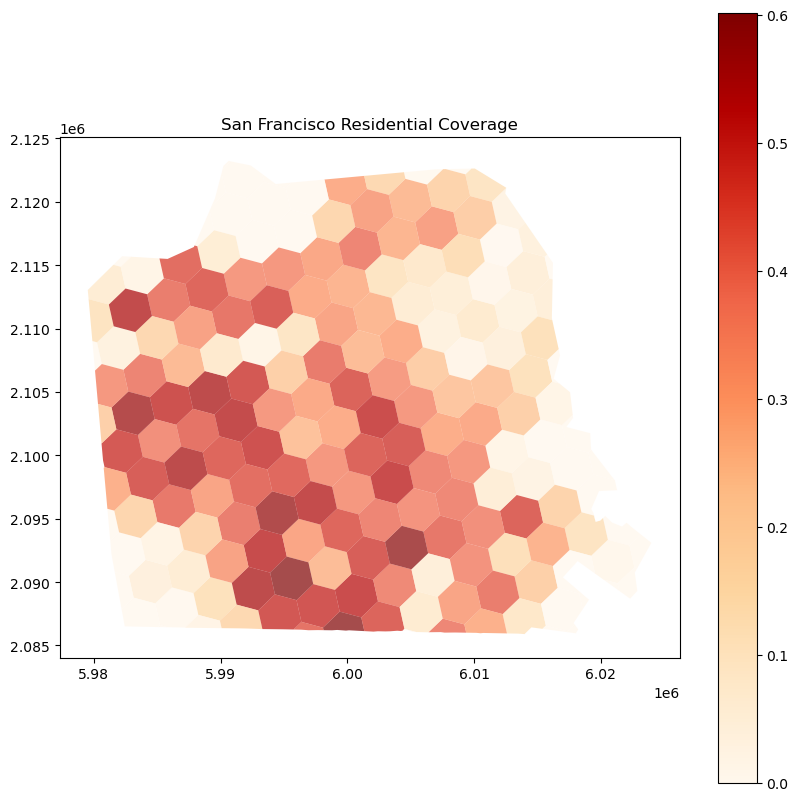

In [82]:
# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Step 4: Plot the hexagonal heatmap based on bike parking density
land_use_coverage.plot(column='RESIDENT_coverage', ax=ax, cmap='OrRd', legend=True, alpha=0.7)

# Step 7: Add title and legend
plt.title('San Francisco Residential Coverage')

# Step 8: Show the plot
plt.show()

Looks correct, can add in road coverage later if I think it would be interesting. There are two NaN rows in there too, but will have to look at that more closely later. May want to drop any hexagons that are too small and are very susceptible to outliers.

### Population Density

In [83]:
# import and clean density
sf_blocks_pop = sf_blocks_cleaned.copy()
sf_blocks_pop = gpd.GeoDataFrame(sf_blocks_pop, columns=["GEOID", "geometry"])
sf_blocks_pop.set_crs("EPSG:4326", inplace=True)
sf_blocks_pop = sf_blocks_pop.to_crs("EPSG:2227")

In [84]:
sf_blocks_pop

GEOID                                           geometry
25     060750156003  POLYGON ((5995598.518 2112884.918, 5996343.169...
26     060750169001  POLYGON ((6002175.882 2108280.029, 6002818.905...
116    060750153001  POLYGON ((6000962.862 2115226.038, 6001459.977...
123    060750217001  POLYGON ((5997652.122 2099941.324, 5998080.788...
161    060750260012  POLYGON ((6002373.752 2092507.650, 6002480.834...
...             ...                                                ...
25235  060750312014  POLYGON ((5994165.070 2091216.665, 5995050.883...
25236  060750313021  POLYGON ((5992466.837 2089850.896, 5992987.742...
25237  060750326013  POLYGON ((5988042.566 2105776.122, 5990219.043...
25238  060750328022  POLYGON ((5989353.218 2103780.211, 5990284.122...
25239  060750329013  POLYGON ((5984952.453 2100225.467, 5987608.369...

[676 rows x 2 columns]

In [85]:
sf_blocks_pop['census_area'] = sf_blocks_pop.geometry.area

In [86]:
sf_blocks_pop = sf_blocks_pop.rename(columns={'GEOID': 'geoid'})

In [87]:
sf_pop_data = pd.read_csv('data/DECENNIALDHC2020.H8_2024-12-10T155731/DECENNIALDHC2020.H8-Data.csv', skiprows=1)

In [88]:
acs_sf_pop_data = pd.read_csv('data/ACSDT5Y2022.B01003_2024-12-10T163001/ACSDT5Y2022.B01003-Data.csv', skiprows=1)

In [89]:
acs_sf_pop_data['geoid'] = acs_sf_pop_data['Geography'].str.slice(9, 21)

In [90]:
acs_sf_pop_data = acs_sf_pop_data[['geoid', 'Estimate!!Total']]

In [91]:
acs_sf_pop_data = acs_sf_pop_data.rename(columns={'Estimate!!Total': 'total_pop'})

In [92]:
acs_sf_pop_data

geoid  total_pop
0    060750101011        795
1    060750101012       1326
2    060750101021       1908
3    060750102011       1219
4    060750102012       1254
..            ...        ...
676  060759805011        129
677  060759806001       1172
678  060759809001        315
679  060759901000          0
680  060759902000          0

[681 rows x 2 columns]

In [93]:
acs_sf_pop_geo_data = sf_blocks_pop.merge(acs_sf_pop_data, on='geoid', how='left')

In [94]:
acs_sf_pop_geo_data

geoid                                           geometry  \
0    060750156003  POLYGON ((5995598.518 2112884.918, 5996343.169...   
1    060750169001  POLYGON ((6002175.882 2108280.029, 6002818.905...   
2    060750153001  POLYGON ((6000962.862 2115226.038, 6001459.977...   
3    060750217001  POLYGON ((5997652.122 2099941.324, 5998080.788...   
4    060750260012  POLYGON ((6002373.752 2092507.650, 6002480.834...   
..            ...                                                ...   
671  060750312014  POLYGON ((5994165.070 2091216.665, 5995050.883...   
672  060750313021  POLYGON ((5992466.837 2089850.896, 5992987.742...   
673  060750326013  POLYGON ((5988042.566 2105776.122, 5990219.043...   
674  060750328022  POLYGON ((5989353.218 2103780.211, 5990284.122...   
675  060750329013  POLYGON ((5984952.453 2100225.467, 5987608.369...   

      census_area  total_pop  
0    1.383758e+06       1098  
1    1.516758e+06       1348  
2    1.352755e+06        867  
3    7.790491e+06       1043  
4    1.066707e+06       2069  
..            ...        ...  
671  1.149110e+06       1131  
672  1.716273e+06       1376  
673  1.491885e+06       1398  
674  1.896285e+06       1667  
675  1.803347e+06       1352  

[676 rows x 4 columns]

In [95]:
pop_hex = clipped_hex_grid[['h3_index', 'geometry']]

In [96]:
pop_overlay = gpd.overlay(pop_hex, acs_sf_pop_geo_data, how='intersection')

In [97]:
pop_overlay

h3_index         geoid   census_area  total_pop  \
0     8828309555fffff  060750262011  1.300646e+06       1057   
1     8828309555fffff  060750263033  1.108879e+06       1333   
2     8828309555fffff  060750262012  1.626763e+06       1237   
3     882830942dfffff  060750604002  5.283932e+07        679   
4     8828309553fffff  060750313023  3.771763e+06       2410   
...               ...           ...           ...        ...   
1591  88283080d9fffff  060750102021  2.754208e+06        905   
1592  88283080d9fffff  060750126022  3.777549e+06       1366   
1593  88283080d9fffff  060750102022  1.348028e+06        954   
1594  88283080d9fffff  060750101011  3.736008e+06        795   
1595  88283080ddfffff  060750101011  3.736008e+06        795   

                                               geometry  
0     POLYGON ((5997275.838 2086621.803, 5996842.739...  
1     POLYGON ((5998083.382 2086406.570, 5998127.832...  
2     POLYGON ((5996449.511 2086842.042, 5996842.739...  
3     POLYGON ((5989954.716 2086957.954, 5990086.597...  
4     POLYGON ((5992976.150 2087767.793, 5993140.569...  
...                                                 ...  
1591  POLYGON ((6005165.014 2122399.253, 6006594.489...  
1592  POLYGON ((6004590.117 2121812.424, 6004473.275...  
1593  POLYGON ((6005439.133 2121586.576, 6005430.956...  
1594  POLYGON ((6007563.152 2122576.863, 6007293.319...  
1595  POLYGON ((6007768.596 2122581.093, 6008232.089...  

[1596 rows x 5 columns]

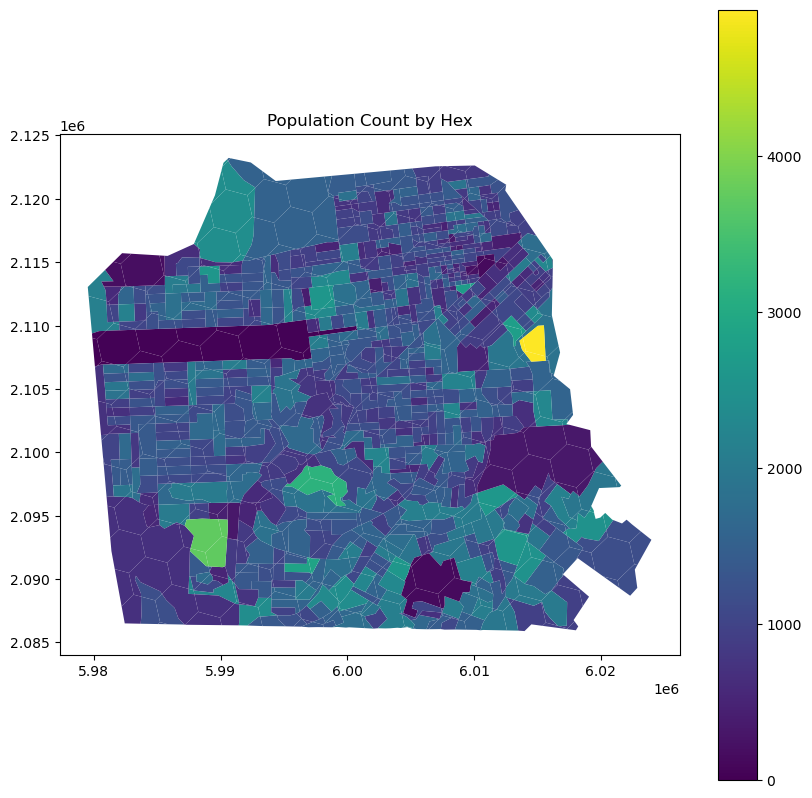

In [98]:
# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

pop_overlay.plot(ax=ax, column='total_pop', legend=True)

# Step 7: Add title
plt.title('Population Count by Hex')

# Step 8: Show the plot
plt.show()

It is clipped correctly.

In [99]:
pop_overlay['clipped_area'] = pop_overlay.geometry.area

In [100]:
pop_overlay['clipped_total_population'] = (pop_overlay['clipped_area']/pop_overlay['census_area'])*pop_overlay['total_pop']

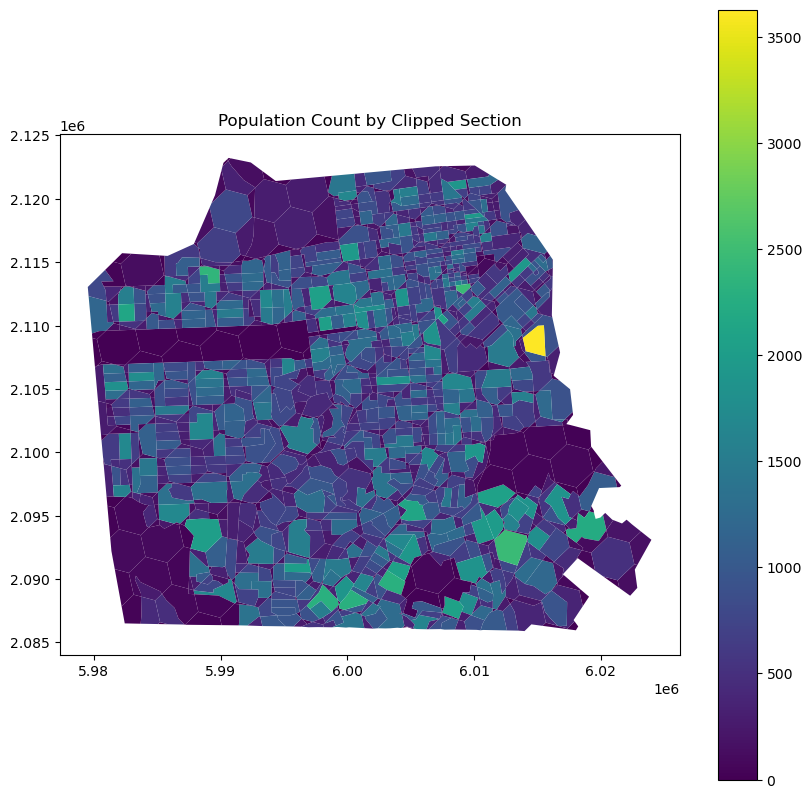

In [101]:
# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

pop_overlay.plot(ax=ax, column='clipped_total_population', legend=True)

# Step 7: Add title
plt.title('Population Count by Clipped Section')

# Step 8: Show the plot
plt.show()

Looks correct. Sicne it's by count smaller areas would be expected to have small values.

In [102]:
pop_overlay

h3_index         geoid   census_area  total_pop  \
0     8828309555fffff  060750262011  1.300646e+06       1057   
1     8828309555fffff  060750263033  1.108879e+06       1333   
2     8828309555fffff  060750262012  1.626763e+06       1237   
3     882830942dfffff  060750604002  5.283932e+07        679   
4     8828309553fffff  060750313023  3.771763e+06       2410   
...               ...           ...           ...        ...   
1591  88283080d9fffff  060750102021  2.754208e+06        905   
1592  88283080d9fffff  060750126022  3.777549e+06       1366   
1593  88283080d9fffff  060750102022  1.348028e+06        954   
1594  88283080d9fffff  060750101011  3.736008e+06        795   
1595  88283080ddfffff  060750101011  3.736008e+06        795   

                                               geometry  clipped_area  \
0     POLYGON ((5997275.838 2086621.803, 5996842.739...  1.198286e+05   
1     POLYGON ((5998083.382 2086406.570, 5998127.832...  4.506499e+05   
2     POLYGON ((5996449.511 2086842.042, 5996842.739...  3.398267e+05   
3     POLYGON ((5989954.716 2086957.954, 5990086.597...  1.955172e+06   
4     POLYGON ((5992976.150 2087767.793, 5993140.569...  2.152848e+06   
...                                                 ...           ...   
1591  POLYGON ((6005165.014 2122399.253, 6006594.489...  1.393997e+06   
1592  POLYGON ((6004590.117 2121812.424, 6004473.275...  5.055998e+05   
1593  POLYGON ((6005439.133 2121586.576, 6005430.956...  2.658228e+05   
1594  POLYGON ((6007563.152 2122576.863, 6007293.319...  3.429138e+04   
1595  POLYGON ((6007768.596 2122581.093, 6008232.089...  4.466514e+05   

      clipped_total_population  
0                    97.381478  
1                   541.732813  
2                   258.406167  
3                    25.124505  
4                  1375.580674  
...                        ...  
1591                458.050779  
1592                182.830010  
1593                188.122965  
1594                  7.297000  
1595                 95.044736  

[1596 rows x 7 columns]

In [103]:
pop_summary = pop_overlay.groupby('h3_index')['clipped_total_population'].sum().reset_index()

In [104]:
pop_hex_summary = pop_hex.merge(pop_summary, on='h3_index', how='left')

In [105]:
pop_hex_summary['hex_area'] = pop_hex_summary.geometry.area

In [106]:
pop_hex_summary['pop_density'] = pop_hex_summary['clipped_total_population']/pop_hex_summary['hex_area']

In [107]:
pop_hex_summary

h3_index                                           geometry  \
0    8828309555fffff  POLYGON ((5996380.891 2086860.332, 5998083.382...   
1    882830942dfffff  POLYGON ((5988252.579 2087411.663, 5989954.716...   
2    8828309553fffff  POLYGON ((5989954.716 2086957.954, 5991273.900...   
3    8828309557fffff  POLYGON ((5992976.150 2087767.793, 5994295.368...   
4    8828309425fffff  POLYGON ((5988252.579 2087411.663, 5987869.641...   
5    8828309519fffff  POLYGON ((5991273.900 2088221.493, 5990890.883...   
6    882830951dfffff  POLYGON ((5994295.368 2089031.363, 5993912.274...   
7    882830951bfffff  POLYGON ((5989188.761 2090392.312, 5988805.810...   
8    8828309429fffff  POLYGON ((5985231.408 2086601.874, 5985841.955...   
9    882830942bfffff  POLYGON ((5983146.652 2088772.664, 5984848.547...   
10   8828309421fffff  POLYGON ((5985231.408 2086601.874, 5984848.547...   
11   882830943dfffff  POLYGON ((5982763.855 2090489.680, 5983146.652...   
12   8828309423fffff  POLYGON ((5983146.652 2088772.664, 5982763.855...   
13   8828309427fffff  POLYGON ((5986167.632 2089582.468, 5985784.759...   
14   8828309435fffff  POLYGON ((5981998.313 2093923.478, 5983700.071...   
15   88283095c9fffff  POLYGON ((5984082.879 2091753.075, 5983700.071...   
16   8828309437fffff  POLYGON ((5981615.568 2095640.260, 5981998.313...   
17   88283095cbfffff  POLYGON ((5981998.313 2093923.478, 5981615.568...   
18   88283095c1fffff  POLYGON ((5985019.065 2094733.356, 5984636.244...   
19   88283095ddfffff  POLYGON ((5980850.131 2099073.593, 5982551.747...   
20   88283095c3fffff  POLYGON ((5982934.505 2096903.578, 5982551.747...   
21   88283095c7fffff  POLYGON ((5985955.210 2097713.508, 5985572.376...   
22   88283095d1fffff  POLYGON ((5980850.131 2099073.593, 5980785.706...   
23   8828309511fffff  POLYGON ((5992210.039 2091202.197, 5991827.010...   
24   8828309515fffff  POLYGON ((5995231.465 2092012.122, 5994848.357...   
25   88283095cdfffff  POLYGON ((5987103.817 2092562.933, 5986720.930...   
26   8828309513fffff  POLYGON ((5990124.903 2093372.832, 5989741.939...   
27   8828309517fffff  POLYGON ((5993146.137 2094182.772, 5992763.095...   
28   88283095c5fffff  POLYGON ((5988039.960 2095543.269, 5987657.061...   
29   88283095e9fffff  POLYGON ((5991061.003 2096353.223, 5990678.026...   
30   88283095edfffff  POLYGON ((5994082.195 2097163.217, 5993699.140...   
31   88283095ebfffff  POLYGON ((5988976.062 2098523.476, 5988593.151...   
32   88283095e1fffff  POLYGON ((5991997.063 2099333.485, 5991614.073...   
33   88283095d5fffff  POLYGON ((5981786.283 2102053.376, 5983487.885...   
34   8828309589fffff  POLYGON ((5983870.654 2099883.548, 5983487.885...   
35   88283095d7fffff  POLYGON ((5981403.571 2103769.799, 5981786.283...   
36   882830958bfffff  POLYGON ((5981786.283 2102053.376, 5981403.571...   
37   8828309581fffff  POLYGON ((5984806.756 2102863.372, 5984423.968...   
38   882830959dfffff  POLYGON ((5980638.200 2107202.414, 5982339.659...   
39   8828309583fffff  POLYGON ((5982722.384 2105032.996, 5982339.659...   
40   8828309587fffff  POLYGON ((5985742.811 2105843.043, 5985360.010...   
41   8828309591fffff  POLYGON ((5980255.541 2108918.605, 5980638.200...   
42   88283082cbfffff  POLYGON ((6003146.660 2099593.444, 6002763.371...   
43   88283082d9fffff  POLYGON ((5998039.509 2100953.624, 5997656.359...   
44   88283082ddfffff  POLYGON ((6001060.953 2101763.751, 6000677.724...   
45   88283082c3fffff  POLYGON ((6004082.544 2102573.914, 6003699.236...   
46   88283082dbfffff  POLYGON ((5995954.182 2103123.704, 5995571.096...   
47   88283082d1fffff  POLYGON ((5998975.434 2103933.841, 5998592.269...   
48   88283082d5fffff  POLYGON ((6001996.834 2104744.020, 6001613.591...   
49   88283082d3fffff  POLYGON ((5996890.107 2106103.732, 5996507.008...   
50   88283082d7fffff  POLYGON ((5999911.316 2106913.926, 5999528.138...   
51   882830828bfffff  POLYGON ((6002932.673 2107724.162, 6002549.417...   
52   88283095e5fffff  POLYGON ((59950

In [108]:
pop_hex_summary.crs

<Projected CRS: EPSG:2227>
Name: NAD83 / California zone 3 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Alameda; Calaveras; Contra Costa; Madera; Marin; Mariposa; Merced; Mono; San Francisco; San Joaquin; San Mateo; Santa Clara; Santa Cruz; Stanislaus; Tuolumne.
- bounds: (-123.02, 36.73, -117.83, 38.71)
Coordinate Operation:
- name: SPCS83 California zone 3 (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

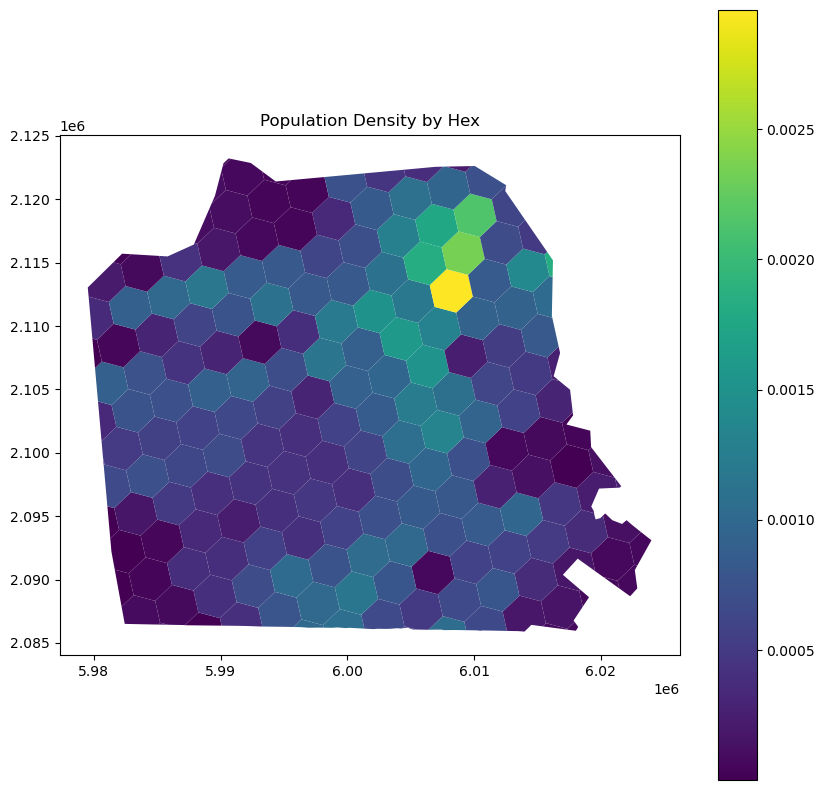

In [109]:
# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

pop_hex_summary.plot(ax=ax, column='pop_density', legend=True)

# Step 7: Add title
plt.title('Population Density by Hex')

# Step 8: Show the plot
plt.show()

In [110]:
# sf_pop_data = sf_pop_data[['Geography', ' !!Total']]

In [111]:
# sf_pop_data['GEOID'] = sf_pop_data['Geography'].str.slice(9, 21)
# sf_pop_data = sf_pop_data[['GEOID', ' !!Total']]

In [112]:
# sf_pop_data = sf_pop_data.rename(columns={'GEOID': 'geoid', ' !!Total': 'total_pop'})

In [113]:
# sf_pop_geo_data = sf_blocks_pop.merge(sf_pop_data, on='geoid', how='left')

In [114]:
# sf_pop_geo_data

### Hill Gradient

In [115]:
# import and clean hill gradient


### Temperature

In [116]:
sf_airport_2024 = pd.read_csv('data/LCD_USW00023234_2024.csv')
sf_downtown_2023 = pd.read_csv('data/LCD_USW00023272_2023.csv')
sf_downtown_2024 = pd.read_csv('data/LCD_USW00023272_2024.csv')

/var/folders/6b/33d16tr12453_x5yvp1kg99c0000gn/T/ipykernel_29373/631318735.py:1: DtypeWarning: Columns (58,60,61,77,90,91,92,93,94,95,96,97,98,99,100,101,108,109,110,111,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  sf_airport_2024 = pd.read_csv('data/LCD_USW00023234_2024.csv')


In [117]:
def clean_weather_data(df):
    """
    Reads a dataframe, selects specific columns, and removes rows with NA in all selected columns.
    
    Returns:
    - DataFrame: Cleaned DataFrame with specified columns.
    """
    # Define the columns to select
    selected_columns = [
        'STATION',
        'DATE',
        'LATITUDE',
        'LONGITUDE',
        'ELEVATION',
        'NAME',
        'MonthlyMaximumTemperature',
        'MonthlyMeanTemperature',
        'MonthlyMinimumTemperature',
        'MonthlyDaysWithGT001Precip',
        'MonthlyDaysWithGT010Precip'
    ]
    # Define the subset of columns to check for NA values
    columns_to_check = [
        'MonthlyMaximumTemperature',
        'MonthlyMeanTemperature',
        'MonthlyMinimumTemperature',
        'MonthlyDaysWithGT001Precip',
        'MonthlyDaysWithGT010Precip'
    ]
    
    # Select only the specified columns
    df_selected = df[selected_columns]
    
    # Drop rows where all selected columns are NA
    df_cleaned = df_selected.dropna(subset=columns_to_check, how='all')
    
    return df_cleaned

In [118]:
cleaned_sf_airport_2024 = clean_weather_data(sf_airport_2024)
cleaned_sf_downtown_2023 = clean_weather_data(sf_downtown_2023)
cleaned_sf_downtown_2024 = clean_weather_data(sf_downtown_2024)

In [119]:
cleaned_sf_downtown_2023.head()

STATION                 DATE  LATITUDE  LONGITUDE  ELEVATION  \
1    USW00023272  2023-01-01T00:00:00   37.7705  -122.4269       45.7   
138  USW00023272  2023-02-01T00:00:00   37.7705  -122.4269       45.7   
225  USW00023272  2023-03-01T00:00:00   37.7705  -122.4269       45.7   
383  USW00023272  2023-04-01T00:00:00   37.7705  -122.4269       45.7   
425  USW00023272  2023-05-01T00:00:00   37.7705  -122.4269       45.7   

                              NAME  MonthlyMaximumTemperature  \
1    SAN FRANCISCO DOWNTOWN, CA US                      14.56   
138  SAN FRANCISCO DOWNTOWN, CA US                      13.75   
225  SAN FRANCISCO DOWNTOWN, CA US                      13.86   
383  SAN FRANCISCO DOWNTOWN, CA US                      16.09   
425  SAN FRANCISCO DOWNTOWN, CA US                      16.40   

     MonthlyMeanTemperature  MonthlyMinimumTemperature  \
1                     11.57                       8.58   
138                   10.27                       6.79   
225                   10.69                       7.51   
383                   12.37                       8.64   
425                   13.53                      10.66   

     MonthlyDaysWithGT001Precip  MonthlyDaysWithGT010Precip  
1                          13.0                        13.0  
138                        10.0                         8.0  
225                        18.0                        13.0  
383                         3.0                         1.0  
425                         5.0                         2.0

Annoyingly there is no data for 2023-10. Since it is not a peak, like February or August, I am going to make those values the average of the month before and after.

In [120]:
temperatures = ['MonthlyMaximumTemperature',
        'MonthlyMeanTemperature',
        'MonthlyMinimumTemperature']
cleaned_sf_downtown_2023[temperatures] = cleaned_sf_downtown_2023[temperatures].apply(lambda group: group.interpolate(method='linear'))

In [121]:
cleaned_sf_downtown_2023.head()

STATION                 DATE  LATITUDE  LONGITUDE  ELEVATION  \
1    USW00023272  2023-01-01T00:00:00   37.7705  -122.4269       45.7   
138  USW00023272  2023-02-01T00:00:00   37.7705  -122.4269       45.7   
225  USW00023272  2023-03-01T00:00:00   37.7705  -122.4269       45.7   
383  USW00023272  2023-04-01T00:00:00   37.7705  -122.4269       45.7   
425  USW00023272  2023-05-01T00:00:00   37.7705  -122.4269       45.7   

                              NAME  MonthlyMaximumTemperature  \
1    SAN FRANCISCO DOWNTOWN, CA US                      14.56   
138  SAN FRANCISCO DOWNTOWN, CA US                      13.75   
225  SAN FRANCISCO DOWNTOWN, CA US                      13.86   
383  SAN FRANCISCO DOWNTOWN, CA US                      16.09   
425  SAN FRANCISCO DOWNTOWN, CA US                      16.40   

     MonthlyMeanTemperature  MonthlyMinimumTemperature  \
1                     11.57                       8.58   
138                   10.27                       6.79   
225                   10.69                       7.51   
383                   12.37                       8.64   
425                   13.53                      10.66   

     MonthlyDaysWithGT001Precip  MonthlyDaysWithGT010Precip  
1                          13.0                        13.0  
138                        10.0                         8.0  
225                        18.0                        13.0  
383                         3.0                         1.0  
425                         5.0                         2.0

In [122]:
cleaned_sf_downtown_2024.head()

STATION                 DATE  LATITUDE  LONGITUDE  ELEVATION  \
1    USW00023272  2024-01-01T00:00:00   37.7705  -122.4269       45.7   
149  USW00023272  2024-02-01T00:00:00   37.7705  -122.4269       45.7   
283  USW00023272  2024-03-01T00:00:00   37.7705  -122.4269       45.7   
424  USW00023272  2024-05-01T00:00:00   37.7705  -122.4269       45.7   
456  USW00023272  2024-06-01T00:00:00   37.7705  -122.4269       45.7   

                              NAME  MonthlyMaximumTemperature  \
1    SAN FRANCISCO DOWNTOWN, CA US                      15.18   
149  SAN FRANCISCO DOWNTOWN, CA US                      15.56   
283  SAN FRANCISCO DOWNTOWN, CA US                      15.89   
424  SAN FRANCISCO DOWNTOWN, CA US                      18.12   
456  SAN FRANCISCO DOWNTOWN, CA US                      19.04   

     MonthlyMeanTemperature  MonthlyMinimumTemperature  \
1                     12.44                       9.70   
149                   12.59                       9.62   
283                   12.94                      10.00   
424                   14.26                      10.40   
456                   15.16                      11.27   

     MonthlyDaysWithGT001Precip  MonthlyDaysWithGT010Precip  
1                          15.0                        12.0  
149                        13.0                        12.0  
283                        15.0                        11.0  
424                         3.0                         1.0  
456                         0.0                         0.0

Annoyingly there is no data for 2024-04. Since it is not a peak, like February or August, I am going to make those values the average of the month before and after. I will also take the rain days from SF Airport weather station, slightly south of San Francisco.

In [123]:
# Append the row to sf_downtown_weather_data
cleaned_sf_downtown_2024 = pd.concat([cleaned_sf_downtown_2024, cleaned_sf_airport_2024.iloc[[3]]], ignore_index=True)

In [124]:
cleaned_sf_downtown_2024

STATION                 DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  USW00023272  2024-01-01T00:00:00   37.7705  -122.4269       45.7   
1  USW00023272  2024-02-01T00:00:00   37.7705  -122.4269       45.7   
2  USW00023272  2024-03-01T00:00:00   37.7705  -122.4269       45.7   
3  USW00023272  2024-05-01T00:00:00   37.7705  -122.4269       45.7   
4  USW00023272  2024-06-01T00:00:00   37.7705  -122.4269       45.7   
5  USW00023272  2024-07-01T00:00:00   37.7705  -122.4269       45.7   
6  USW00023272  2024-08-01T00:00:00   37.7705  -122.4269       45.7   
7  USW00023272  2024-09-01T00:00:00   37.7705  -122.4269       45.7   
8  USW00023234  2024-04-01T00:00:00   37.6197  -122.3647        2.4   

                                         NAME  MonthlyMaximumTemperature  \
0               SAN FRANCISCO DOWNTOWN, CA US                      15.18   
1               SAN FRANCISCO DOWNTOWN, CA US                      15.56   
2               SAN FRANCISCO DOWNTOWN, CA US                      15.89   
3               SAN FRANCISCO DOWNTOWN, CA US                      18.12   
4               SAN FRANCISCO DOWNTOWN, CA US                      19.04   
5               SAN FRANCISCO DOWNTOWN, CA US                      20.39   
6               SAN FRANCISCO DOWNTOWN, CA US                      20.27   
7               SAN FRANCISCO DOWNTOWN, CA US                        NaN   
8  SAN FRANCISCO INTERNATIONAL AIRPORT, CA US                      18.44   

   MonthlyMeanTemperature  MonthlyMinimumTemperature  \
0                   12.44                       9.70   
1                   12.59                       9.62   
2                   12.94                      10.00   
3                   14.26                      10.40   
4                   15.16                      11.27   
5                   16.68                      12.96   
6                   16.66                      13.05   
7                     NaN                        NaN   
8                   14.28                      10.11   

   MonthlyDaysWithGT001Precip  MonthlyDaysWithGT010Precip  
0                        15.0                        12.0  
1                        13.0                        12.0  
2                        15.0                        11.0  
3                         3.0                         1.0  
4                         0.0                         0.0  
5                         1.0                         0.0  
6                         1.0                         0.0  
7                         0.0                         0.0  
8                         3.0                         2.0

In [125]:
# Sort by the DATE column
cleaned_sf_downtown_2024 = cleaned_sf_downtown_2024.sort_values(by='DATE', ascending=True)

# Reset the index after sorting
cleaned_sf_downtown_2024.reset_index(drop=True, inplace=True)

In [126]:
cleaned_sf_downtown_2024

STATION                 DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  USW00023272  2024-01-01T00:00:00   37.7705  -122.4269       45.7   
1  USW00023272  2024-02-01T00:00:00   37.7705  -122.4269       45.7   
2  USW00023272  2024-03-01T00:00:00   37.7705  -122.4269       45.7   
3  USW00023234  2024-04-01T00:00:00   37.6197  -122.3647        2.4   
4  USW00023272  2024-05-01T00:00:00   37.7705  -122.4269       45.7   
5  USW00023272  2024-06-01T00:00:00   37.7705  -122.4269       45.7   
6  USW00023272  2024-07-01T00:00:00   37.7705  -122.4269       45.7   
7  USW00023272  2024-08-01T00:00:00   37.7705  -122.4269       45.7   
8  USW00023272  2024-09-01T00:00:00   37.7705  -122.4269       45.7   

                                         NAME  MonthlyMaximumTemperature  \
0               SAN FRANCISCO DOWNTOWN, CA US                      15.18   
1               SAN FRANCISCO DOWNTOWN, CA US                      15.56   
2               SAN FRANCISCO DOWNTOWN, CA US                      15.89   
3  SAN FRANCISCO INTERNATIONAL AIRPORT, CA US                      18.44   
4               SAN FRANCISCO DOWNTOWN, CA US                      18.12   
5               SAN FRANCISCO DOWNTOWN, CA US                      19.04   
6               SAN FRANCISCO DOWNTOWN, CA US                      20.39   
7               SAN FRANCISCO DOWNTOWN, CA US                      20.27   
8               SAN FRANCISCO DOWNTOWN, CA US                        NaN   

   MonthlyMeanTemperature  MonthlyMinimumTemperature  \
0                   12.44                       9.70   
1                   12.59                       9.62   
2                   12.94                      10.00   
3                   14.28                      10.11   
4                   14.26                      10.40   
5                   15.16                      11.27   
6                   16.68                      12.96   
7                   16.66                      13.05   
8                     NaN                        NaN   

   MonthlyDaysWithGT001Precip  MonthlyDaysWithGT010Precip  
0                        15.0                        12.0  
1                        13.0                        12.0  
2                        15.0                        11.0  
3                         3.0                         2.0  
4                         3.0                         1.0  
5                         0.0                         0.0  
6                         1.0                         0.0  
7                         1.0                         0.0  
8                         0.0                         0.0

In [127]:
import numpy as np
# interpolate the temperature data for the April 2024 between both SF downtown temperatures
cleaned_sf_downtown_2024.loc[3, temperatures] = np.nan

cleaned_sf_downtown_2024[temperatures] = cleaned_sf_downtown_2024[temperatures].interpolate(method='linear')

In [128]:
cleaned_sf_downtown_2024

STATION                 DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  USW00023272  2024-01-01T00:00:00   37.7705  -122.4269       45.7   
1  USW00023272  2024-02-01T00:00:00   37.7705  -122.4269       45.7   
2  USW00023272  2024-03-01T00:00:00   37.7705  -122.4269       45.7   
3  USW00023234  2024-04-01T00:00:00   37.6197  -122.3647        2.4   
4  USW00023272  2024-05-01T00:00:00   37.7705  -122.4269       45.7   
5  USW00023272  2024-06-01T00:00:00   37.7705  -122.4269       45.7   
6  USW00023272  2024-07-01T00:00:00   37.7705  -122.4269       45.7   
7  USW00023272  2024-08-01T00:00:00   37.7705  -122.4269       45.7   
8  USW00023272  2024-09-01T00:00:00   37.7705  -122.4269       45.7   

                                         NAME  MonthlyMaximumTemperature  \
0               SAN FRANCISCO DOWNTOWN, CA US                     15.180   
1               SAN FRANCISCO DOWNTOWN, CA US                     15.560   
2               SAN FRANCISCO DOWNTOWN, CA US                     15.890   
3  SAN FRANCISCO INTERNATIONAL AIRPORT, CA US                     17.005   
4               SAN FRANCISCO DOWNTOWN, CA US                     18.120   
5               SAN FRANCISCO DOWNTOWN, CA US                     19.040   
6               SAN FRANCISCO DOWNTOWN, CA US                     20.390   
7               SAN FRANCISCO DOWNTOWN, CA US                     20.270   
8               SAN FRANCISCO DOWNTOWN, CA US                     20.270   

   MonthlyMeanTemperature  MonthlyMinimumTemperature  \
0                   12.44                       9.70   
1                   12.59                       9.62   
2                   12.94                      10.00   
3                   13.60                      10.20   
4                   14.26                      10.40   
5                   15.16                      11.27   
6                   16.68                      12.96   
7                   16.66                      13.05   
8                   16.66                      13.05   

   MonthlyDaysWithGT001Precip  MonthlyDaysWithGT010Precip  
0                        15.0                        12.0  
1                        13.0                        12.0  
2                        15.0                        11.0  
3                         3.0                         2.0  
4                         3.0                         1.0  
5                         0.0                         0.0  
6                         1.0                         0.0  
7                         1.0                         0.0  
8                         0.0                         0.0

In [129]:
# last row does not have accurate data and is not part of our analysis
cleaned_sf_downtown_2024 = cleaned_sf_downtown_2024.drop(cleaned_sf_downtown_2024.index[-1])

In [130]:
sf_downtown_weather_data = pd.concat([cleaned_sf_downtown_2023, cleaned_sf_downtown_2024], ignore_index=True)

In [131]:
sf_downtown_weather_data['DATE'] = sf_downtown_weather_data['DATE'].str[:7]

In [132]:
sf_downtown_weather_data

STATION     DATE  LATITUDE  LONGITUDE  ELEVATION  \
0   USW00023272  2023-01   37.7705  -122.4269       45.7   
1   USW00023272  2023-02   37.7705  -122.4269       45.7   
2   USW00023272  2023-03   37.7705  -122.4269       45.7   
3   USW00023272  2023-04   37.7705  -122.4269       45.7   
4   USW00023272  2023-05   37.7705  -122.4269       45.7   
5   USW00023272  2023-06   37.7705  -122.4269       45.7   
6   USW00023272  2023-07   37.7705  -122.4269       45.7   
7   USW00023272  2023-08   37.7705  -122.4269       45.7   
8   USW00023272  2023-09   37.7705  -122.4269       45.7   
9   USW00023272  2023-10   37.7705  -122.4269       45.7   
10  USW00023272  2023-11   37.7705  -122.4269       45.7   
11  USW00023272  2023-12   37.7705  -122.4269       45.7   
12  USW00023272  2024-01   37.7705  -122.4269       45.7   
13  USW00023272  2024-02   37.7705  -122.4269       45.7   
14  USW00023272  2024-03   37.7705  -122.4269       45.7   
15  USW00023234  2024-04   37.6197  -122.3647        2.4   
16  USW00023272  2024-05   37.7705  -122.4269       45.7   
17  USW00023272  2024-06   37.7705  -122.4269       45.7   
18  USW00023272  2024-07   37.7705  -122.4269       45.7   
19  USW00023272  2024-08   37.7705  -122.4269       45.7   

                                          NAME  MonthlyMaximumTemperature  \
0                SAN FRANCISCO DOWNTOWN, CA US                     14.560   
1                SAN FRANCISCO DOWNTOWN, CA US                     13.750   
2                SAN FRANCISCO DOWNTOWN, CA US                     13.860   
3                SAN FRANCISCO DOWNTOWN, CA US                     16.090   
4                SAN FRANCISCO DOWNTOWN, CA US                     16.400   
5                SAN FRANCISCO DOWNTOWN, CA US                     17.480   
6                SAN FRANCISCO DOWNTOWN, CA US                     19.140   
7                SAN FRANCISCO DOWNTOWN, CA US                     21.620   
8                SAN FRANCISCO DOWNTOWN, CA US                     20.260   
9                SAN FRANCISCO DOWNTOWN, CA US                     19.240   
10               SAN FRANCISCO DOWNTOWN, CA US                     18.220   
11               SAN FRANCISCO DOWNTOWN, CA US                     15.680   
12               SAN FRANCISCO DOWNTOWN, CA US                     15.180   
13               SAN FRANCISCO DOWNTOWN, CA US                     15.560   
14               SAN FRANCISCO DOWNTOWN, CA US                     15.890   
15  SAN FRANCISCO INTERNATIONAL AIRPORT, CA US                     17.005   
16               SAN FRANCISCO DOWNTOWN, CA US                     18.120   
17               SAN FRANCISCO DOWNTOWN, CA US                     19.040   
18               SAN FRANCISCO DOWNTOWN, CA US                     20.390   
19               SAN FRANCISCO DOWNTOWN, CA US                     20.270   

    MonthlyMeanTemperature  MonthlyMinimumTemperature  \
0                    11.57                      8.580   
1                    10.27                      6.790   
2                    10.69                      7.510   
3                    12.37                      8.640   
4                    13.53                     10.660   
5                    14.64                     11.800   
6                    15.66                     12.180   
7                    17.84                     14.060   
8                    17.10                     13.940   
9                    15.86                     12.475   
10                   14.62                     11.010   
11                   12.88                     10.070   
12                   12.44                      9.700   
13                   12.59                      9.620   
14                   12.94                     10.000   
15                   13.60                     10.200   
16                   14.26                     10.400   
17                   15.16                     11.270   
18                   16.68                    

### All independent variables have been processed
The variables fall into two categories
##### Static (stay the same over time)
* Docking station density
* Cultural, Institutional, Educational coverage
* Medical coverage
* Office (Management, Information, Professional Services) coverage
* Mixed Uses (Without Residential) coverage
* Mixed Uses (With Residential) coverage
* Open Space coverage
* Industrial (Production, Distribution, Repair) coverage
* Residential coverage
* Retail, Entertainment coverage
* Vacant coverage
* Hotels/Motels coverage
* Population Density
##### Dynamic (change over time)
* Bicycle parking density
* Bike lane density
* Bike path density
* Bike route density
* Neighborway density
* Separated bikeway density
* Monthly Maximum Temperature
* Monthly Mean Temperature
* Monthly Minimum Temperature
* Monthly Days With Greater than 0.01 inches Precipitation
* Monthly Days With Greater than 0.10 inches Precipitation

May combine or remove some features based on multicollinearity etc. Ex. Can mixed uses be combined with other types of land use?

### Import all bike Data

In [133]:
import glob
import os

# Path to the folder containing CSV files
folder_path = 'data/baywheels_data'

# Use glob to get all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Check the list of CSV files found
print("CSV Files Found:", csv_files)

# Load each CSV file and concatenate them into a single DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(df_list, ignore_index=True)

CSV Files Found: ['data/baywheels_data/202305-baywheels-tripdata.csv', 'data/baywheels_data/202308-baywheels-tripdata.csv', 'data/baywheels_data/202302-baywheels-tripdata.csv', 'data/baywheels_data/202301-baywheels-tripdata.csv', 'data/baywheels_data/202306-baywheels-tripdata.csv', 'data/baywheels_data/202307-baywheels-tripdata.csv', 'data/baywheels_data/202410-baywheels-tripdata.csv', 'data/baywheels_data/202303-baywheels-tripdata.csv', 'data/baywheels_data/202309-baywheels-tripdata.csv', 'data/baywheels_data/202304-baywheels-tripdata.csv', 'data/baywheels_data/202406-baywheels-tripdata.csv', 'data/baywheels_data/202401-baywheels-tripdata.csv', 'data/baywheels_data/202311-baywheels-tripdata.csv', 'data/baywheels_data/202312-baywheels-tripdata.csv', 'data/baywheels_data/202408-baywheels-tripdata.csv', 'data/baywheels_data/202402-baywheels-tripdata.csv', 'data/baywheels_data/202405-baywheels-tripdata.csv', 'data/baywheels_data/202404-baywheels-tripdata.csv', 'data/baywheels_data/202403-

Number of points within bounding box: 4978497
Original Bay Wheels DataFrame: 4978497 rows
Cleaned Bay Wheels DataFrame: 4474972 rows
Removed: 503525 rows


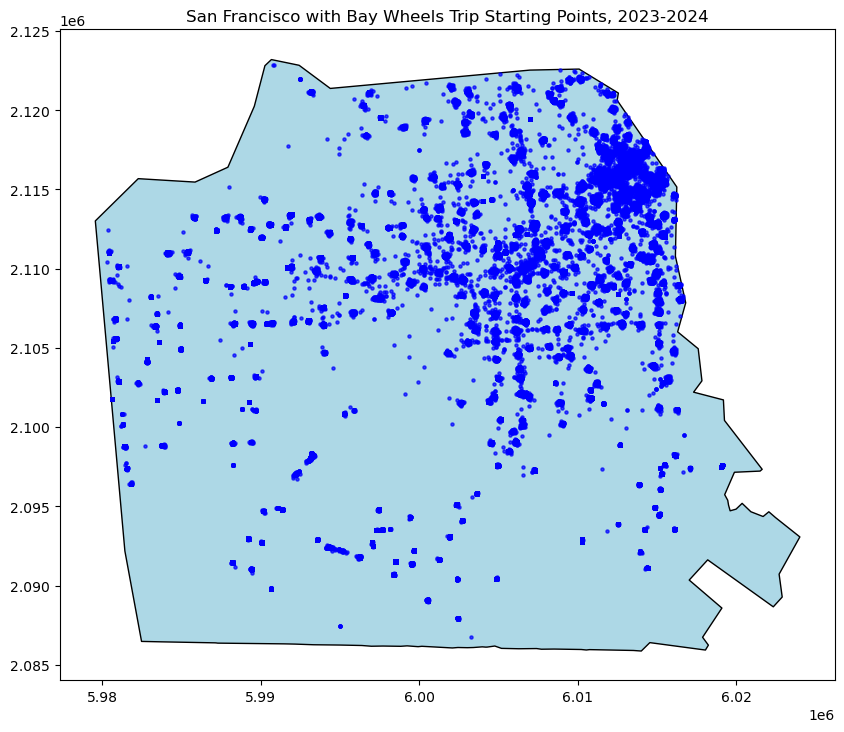

In [134]:
# repeating process from above

baywheels_gdf = gpd.GeoDataFrame(
    combined_df, 
    geometry=gpd.points_from_xy(combined_df.start_lng, combined_df.start_lat),
    crs="EPSG:4326"  # WGS84 coordinate reference system
)

# Define the bounding box (min_x, min_y, max_x, max_y)
min_x, min_y, max_x, max_y = -122.529488, 37.694416, -122.354736, 37.813581

# Create a bounding box as a Shapely Polygon
bounding_box = box(min_x, min_y, max_x, max_y)

# Filter points within the bounding box
baywheels_gdf = baywheels_gdf[baywheels_gdf.geometry.apply(lambda point: point.within(bounding_box))]

# Verify the results
print(f"Number of points within bounding box: {len(baywheels_gdf)}")

# Remove rows with NaN in 'start_station_name'
cleaned_baywheels_gdf = baywheels_gdf.dropna(subset=['start_station_name'])

# Change CRS to 2227
cleaned_baywheels_gdf = cleaned_baywheels_gdf.to_crs(sf_unified_gdf.crs)

# Filter points within the unified San Francisco boundary
cleaned_baywheels_gdf = cleaned_baywheels_gdf[cleaned_baywheels_gdf.geometry.within(sf_unified_gdf.iloc[0].geometry)]

# Verify the cleaned dataset
print(f"Original Bay Wheels DataFrame: {len(baywheels_gdf)} rows")
print(f"Cleaned Bay Wheels DataFrame: {len(cleaned_baywheels_gdf)} rows")
removed_rows = len(baywheels_gdf)-len(cleaned_baywheels_gdf)
print(f"Removed: {removed_rows} rows")

fig, ax = plt.subplots(figsize=(10, 10))
sf_unified_gdf.plot(ax=ax, color='lightblue', edgecolor='black')

# Plot Bay Wheels stations (points)
cleaned_baywheels_gdf.plot(ax=ax, color='blue', markersize=5, alpha=0.7, label='Bay Wheels Trip Starting Points')

ax.set_title("San Francisco with Bay Wheels Trip Starting Points, 2023-2024")
plt.show()

That's a lot of rows, should hopefully be strong enough correlations for my analysis. We can quickly check ending points to find it is much sparser and not as useful as starting points, potentially because of the anonymisation process?

Number of points within bounding box: 4974997
Original Bay Wheels DataFrame: 4974997 rows
Cleaned Bay Wheels DataFrame: 4396267 rows
Removed: 578730 rows


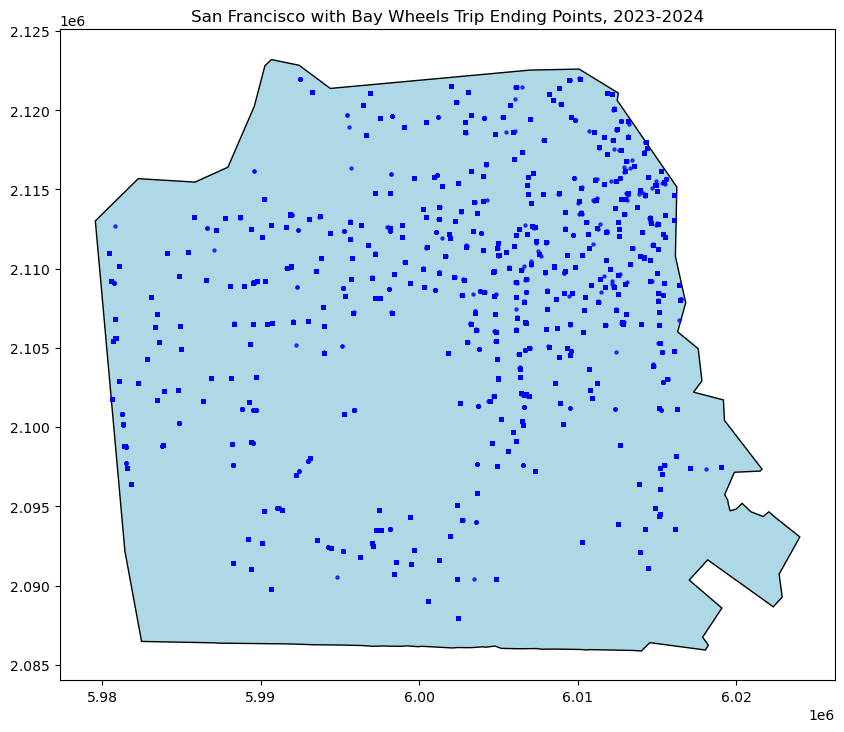

In [212]:
end_baywheels_gdf = gpd.GeoDataFrame(
    combined_df, 
    geometry=gpd.points_from_xy(combined_df.end_lng, combined_df.end_lat),
    crs="EPSG:4326"  # WGS84 coordinate reference system
)

# Filter points within the bounding box
end_baywheels_gdf = end_baywheels_gdf[end_baywheels_gdf.geometry.apply(lambda point: point.within(bounding_box))]

# Verify the results
print(f"Number of points within bounding box: {len(end_baywheels_gdf)}")

# Remove rows with NaN in 'start_station_name'
end_cleaned_baywheels_gdf = end_baywheels_gdf.dropna(subset=['end_station_name'])

# Change CRS to 2227
end_cleaned_baywheels_gdf = end_cleaned_baywheels_gdf.to_crs(sf_unified_gdf.crs)

# Filter points within the unified San Francisco boundary
end_cleaned_baywheels_gdf = end_cleaned_baywheels_gdf[end_cleaned_baywheels_gdf.geometry.within(sf_unified_gdf.iloc[0].geometry)]

# Verify the cleaned dataset
print(f"Original Bay Wheels DataFrame: {len(end_baywheels_gdf)} rows")
print(f"Cleaned Bay Wheels DataFrame: {len(end_cleaned_baywheels_gdf)} rows")
removed_rows = len(end_baywheels_gdf)-len(end_cleaned_baywheels_gdf)
print(f"Removed: {removed_rows} rows")

fig, ax = plt.subplots(figsize=(10, 10))
sf_unified_gdf.plot(ax=ax, color='lightblue', edgecolor='black')

# Plot Bay Wheels stations (points)
end_cleaned_baywheels_gdf.plot(ax=ax, color='blue', markersize=5, alpha=0.7, label='Bay Wheels Trip Ending Points')

ax.set_title("San Francisco with Bay Wheels Trip Ending Points, 2023-2024")
plt.show()

In [135]:
# Step 1: Convert 'started_at' to only show 'YYYY-MM' format
cleaned_baywheels_gdf['started_at'] = cleaned_baywheels_gdf['started_at'].str[:7].apply(pd.Period, freq='M')

# Step 2: Keep only 'ride_id', 'started_at', and 'geometry' columns
cleaned_baywheels_gdf = cleaned_baywheels_gdf[['ride_id', 'started_at', 'geometry']]

# Display the resulting GeoDataFrame
print(cleaned_baywheels_gdf.head())

             ride_id started_at                         geometry
2   761FC46C050F93E5    2023-05  POINT (6008843.486 2114862.590)
3   EC2D3954EEC4BBDB    2023-05  POINT (6008818.842 2114796.434)
6   05C104731C9A1C0A    2023-05  POINT (6003290.253 2116086.498)
8   98817E54504C92E5    2023-05  POINT (6003274.824 2116104.481)
11  3529BB511586BEBD    2023-05  POINT (6014359.346 2117642.031)


Now need to classify each point into a hexagon

In [136]:
# List of hex IDs (from clipped_hex_grid)
bw_clipped_hex_grid = clipped_hex_grid.copy()[['h3_index', 'geometry']]
bw_clipped_hex_grid.head()

h3_index                                           geometry
0  8828309555fffff  POLYGON ((5996380.891 2086860.332, 5998083.382...
1  882830942dfffff  POLYGON ((5988252.579 2087411.663, 5989954.716...
2  8828309553fffff  POLYGON ((5989954.716 2086957.954, 5991273.900...
3  8828309557fffff  POLYGON ((5992976.150 2087767.793, 5994295.368...
4  8828309425fffff  POLYGON ((5988252.579 2087411.663, 5987869.641...

In [137]:
bw_clipped_hex_grid['hex_area'] = bw_clipped_hex_grid.area

In [138]:
# Perform a spatial join to find which hexagon each point falls within
joined_gdf = gpd.sjoin(cleaned_baywheels_gdf, bw_clipped_hex_grid[['h3_index', 'geometry']], how='left', predicate='within')

In [139]:
joined_gdf = joined_gdf.drop(columns=['index_right'])

In [140]:
joined_gdf = joined_gdf.drop(columns=['geometry'])

In [141]:
joined_gdf.head()

ride_id started_at         h3_index
2   761FC46C050F93E5    2023-05  88283082bdfffff
3   EC2D3954EEC4BBDB    2023-05  88283082bdfffff
6   05C104731C9A1C0A    2023-05  88283082bbfffff
8   98817E54504C92E5    2023-05  88283082bbfffff
11  3529BB511586BEBD    2023-05  88283082a7fffff

In [142]:
ride_counts = joined_gdf.groupby(['h3_index', 'started_at']).size().reset_index(name='ride_count')

In [143]:
ride_counts.head()

h3_index started_at  ride_count
0  88283080c9fffff    2023-01        1660
1  88283080c9fffff    2023-02        1684
2  88283080c9fffff    2023-03        1810
3  88283080c9fffff    2023-04        2225
4  88283080c9fffff    2023-05        2403

In [144]:
# Step 1: Create the full grid of hex_id_bp and month_year_bp (covering from 2023-01 to the latest month)
start_date = '2023-01'
end_date = '2024-10'
months = pd.date_range(start=start_date, end=end_date, freq='MS').strftime('%Y-%m')

# We need to create a list of all combinations of hex_id_bp and all months
ride_hex_month_grid = pd.DataFrame(list(product(hex_ids, months)), columns=['h3_index', 'started_at'])
ride_hex_month_grid['started_at'] = ride_hex_month_grid['started_at'].apply(pd.Period, freq='M')

In [145]:
ride_counts = ride_counts.merge(bw_clipped_hex_grid, on='h3_index', how='left')

In [146]:
ride_counts['ride_density'] = ride_counts['ride_count']/ride_counts['hex_area']

In [147]:
ride_counts.head()

h3_index started_at  ride_count  \
0  88283080c9fffff    2023-01        1660   
1  88283080c9fffff    2023-02        1684   
2  88283080c9fffff    2023-03        1810   
3  88283080c9fffff    2023-04        2225   
4  88283080c9fffff    2023-05        2403   

                                            geometry      hex_area  \
0  POLYGON ((6013485.416 2117831.811, 6011782.848...  4.475138e+06   
1  POLYGON ((6013485.416 2117831.811, 6011782.848...  4.475138e+06   
2  POLYGON ((6013485.416 2117831.811, 6011782.848...  4.475138e+06   
3  POLYGON ((6013485.416 2117831.811, 6011782.848...  4.475138e+06   
4  POLYGON ((6013485.416 2117831.811, 6011782.848...  4.475138e+06   

   ride_density  
0      0.000371  
1      0.000376  
2      0.000404  
3      0.000497  
4      0.000537

In [482]:
ride_counts

h3_index started_at  ride_count  \
0     88283080c9fffff    2023-01        1660   
1     88283080c9fffff    2023-02        1684   
2     88283080c9fffff    2023-03        1810   
3     88283080c9fffff    2023-04        2225   
4     88283080c9fffff    2023-05        2403   
...               ...        ...         ...   
2413  88283095ebfffff    2024-06          22   
2414  88283095ebfffff    2024-07          14   
2415  88283095ebfffff    2024-08          22   
2416  88283095ebfffff    2024-09          12   
2417  88283095ebfffff    2024-10          15   

                                               geometry      hex_area  \
0     POLYGON ((6013485.416 2117831.811, 6011782.848...  4.475138e+06   
1     POLYGON ((6013485.416 2117831.811, 6011782.848...  4.475138e+06   
2     POLYGON ((6013485.416 2117831.811, 6011782.848...  4.475138e+06   
3     POLYGON ((6013485.416 2117831.811, 6011782.848...  4.475138e+06   
4     POLYGON ((6013485.416 2117831.811, 6011782.848...  4.475138e+06   
...                                                 ...           ...   
2413  POLYGON ((5988976.062 2098523.476, 5988593.151...  8.244598e+06   
2414  POLYGON ((5988976.062 2098523.476, 5988593.151...  8.244598e+06   
2415  POLYGON ((5988976.062 2098523.476, 5988593.151...  8.244598e+06   
2416  POLYGON ((5988976.062 2098523.476, 5988593.151...  8.244598e+06   
2417  POLYGON ((5988976.062 2098523.476, 5988593.151...  8.244598e+06   

      ride_density  
0         0.000371  
1         0.000376  
2         0.000404  
3         0.000497  
4         0.000537  
...            ...  
2413      0.000003  
2414      0.000002  
2415      0.000003  
2416      0.000001  
2417      0.000002  

[2418 rows x 6 columns]

In [484]:
# Create GeoDataFrame from hexagon geometries, keeping CRS as EPSG:4326
ride_counts_gdf = gpd.GeoDataFrame({
    'ride_density': ride_counts['ride_density'], 
    'geometry': ride_counts['geometry']
}, crs="EPSG:2227")

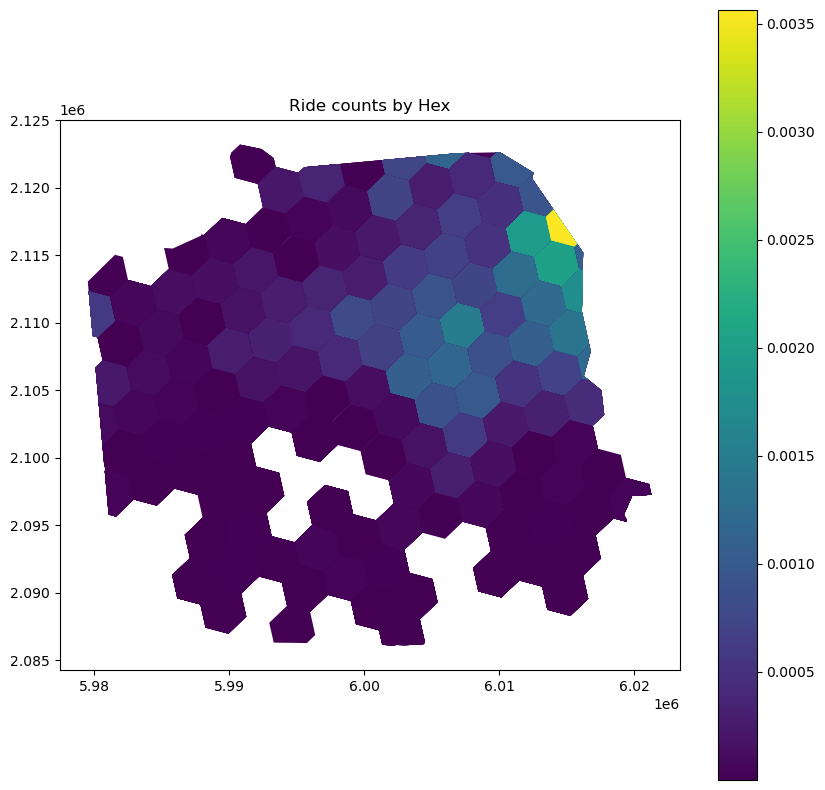

In [485]:
# Step 3: Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

ride_counts_gdf.plot(ax=ax, column='ride_density', legend=True)

# Step 7: Add title
plt.title('Ride counts by Hex')

# Step 8: Show the plot
plt.show()

In [148]:
ride_density = ride_counts.drop(columns=['geometry', 'hex_area', 'ride_count'])

In [149]:
ride_density.head()

h3_index started_at  ride_density
0  88283080c9fffff    2023-01      0.000371
1  88283080c9fffff    2023-02      0.000376
2  88283080c9fffff    2023-03      0.000404
3  88283080c9fffff    2023-04      0.000497
4  88283080c9fffff    2023-05      0.000537

In [150]:
ride_density = ride_hex_month_grid.merge(ride_density, on=['h3_index', 'started_at'], how='left')

In [151]:
ride_density['ride_density'] = ride_density['ride_density'].fillna(0)

#### Static features align

In [152]:
# Docking station density
ride_density = ride_density.merge(clipped_hex_grid, on='h3_index', how='left')

In [153]:
ride_density.head()

h3_index started_at  ride_density  \
0  8828309555fffff    2023-01           0.0   
1  8828309555fffff    2023-02           0.0   
2  8828309555fffff    2023-03           0.0   
3  8828309555fffff    2023-04           0.0   
4  8828309555fffff    2023-05           0.0   

                                            geometry           area  \
0  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
1  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
2  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
3  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
4  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   

   docking_station_count  docking_station_count_density  
0                    0.0                            0.0  
1                    0.0                            0.0  
2                    0.0                            0.0  
3                    0.0                            0.0  
4                    0.0                            0.0

In [154]:
ride_density = ride_density.drop(columns=['geometry', 'area', 'docking_station_count'])

In [155]:
land_use_coverage.head()

h3_index                                           geometry  \
0  88283080c9fffff  POLYGON ((6013485.416 2117831.811, 6011782.848...   
1  88283080cbfffff  POLYGON ((6011399.398 2120001.079, 6009696.958...   
2  88283080d9fffff  POLYGON ((6006292.317 2121359.620, 6004590.117...   
3  88283080ddfffff  POLYGON ((6009313.573 2122170.147, 6007768.596...   
4  8828308201fffff  POLYGON ((6022262.891 2092886.955, 6020559.497...   

            CIE  MED          MIPS          MIXED         MIXRES  \
0  70256.877157  0.0  6.676461e+05  405688.863012  419754.995996   
1  74672.229564  0.0  2.167822e+05  204226.757126  853949.330824   
2      0.000000  0.0  9.453143e+03   70282.860931  132949.134274   
3      0.000000  0.0  0.000000e+00  102148.718942       0.000000   
4      0.000000  0.0  1.716805e+06   66287.095634   20028.460013   

      OPENSPACE           PDR       RESIDENT  ...  MED_coverage  \
0  2.360131e+05  20727.793402  183666.033628  ...           0.0   
1  2.234023e+05  31375.686765  610365.047635  ...           0.0   
2  1.522608e+06      0.000000    7977.952026  ...           0.0   
3  1.006790e+04      0.000000       0.000000  ...           0.0   
4  9.927818e+04      0.000000    8402.948648  ...           0.0   

   MIPS_coverage  MIXED_coverage  MIXRES_coverage  OPENSPACE_coverage  \
0       0.149190        0.090654         0.093797            0.052739   
1       0.043558        0.041035         0.171584            0.044888   
2       0.004297        0.031951         0.060439            0.692186   
3       0.000000        0.228699         0.000000            0.022541   
4       0.473451        0.018280         0.005523            0.027378   

   PDR_coverage  RESIDENT_coverage  RETAIL/ENT_coverage  VACANT_coverage  \
0      0.004632           0.041041             0.032145         0.132424   
1      0.006304           0.122641             0.006613         0.190278   
2      0.000000           0.003627             0.035091         0.110886   
3      0.000000           0.000000             0.123934         0.142596   
4      0.000000           0.002317             0.000000         0.427175   

   VISITOR_coverage  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  

[5 rows x 24 columns]

In [156]:
# Land use coverage
ride_density = ride_density.merge(land_use_coverage, on='h3_index', how='left')

In [157]:
ride_density = ride_density.drop(columns=['geometry', 'CIE', 'MED', 'MIPS', 'MIXED', 'MIXRES', 'OPENSPACE', 'PDR', 'RESIDENT', 'RETAIL/ENT', 'VACANT', 'VISITOR'])

In [158]:
ride_density.head()

h3_index started_at  ride_density  docking_station_count_density  \
0  8828309555fffff    2023-01           0.0                            0.0   
1  8828309555fffff    2023-02           0.0                            0.0   
2  8828309555fffff    2023-03           0.0                            0.0   
3  8828309555fffff    2023-04           0.0                            0.0   
4  8828309555fffff    2023-05           0.0                            0.0   

   CIE_coverage  MED_coverage  MIPS_coverage  MIXED_coverage  MIXRES_coverage  \
0      0.041838           0.0       0.005487        0.005537         0.051047   
1      0.041838           0.0       0.005487        0.005537         0.051047   
2      0.041838           0.0       0.005487        0.005537         0.051047   
3      0.041838           0.0       0.005487        0.005537         0.051047   
4      0.041838           0.0       0.005487        0.005537         0.051047   

   OPENSPACE_coverage  PDR_coverage  RESIDENT_coverage  RETAIL/ENT_coverage  \
0            0.006971      0.045349           0.438451             0.003392   
1            0.006971      0.045349           0.438451             0.003392   
2            0.006971      0.045349           0.438451             0.003392   
3            0.006971      0.045349           0.438451             0.003392   
4            0.006971      0.045349           0.438451             0.003392   

   VACANT_coverage  VISITOR_coverage  
0         0.050282               0.0  
1         0.050282               0.0  
2         0.050282               0.0  
3         0.050282               0.0  
4         0.050282               0.0

In [159]:
# Population Density

In [160]:
ride_density = ride_density.merge(pop_hex_summary, on='h3_index', how='left')

In [161]:
pop_hex_summary.head()

h3_index                                           geometry  \
0  8828309555fffff  POLYGON ((5996380.891 2086860.332, 5998083.382...   
1  882830942dfffff  POLYGON ((5988252.579 2087411.663, 5989954.716...   
2  8828309553fffff  POLYGON ((5989954.716 2086957.954, 5991273.900...   
3  8828309557fffff  POLYGON ((5992976.150 2087767.793, 5994295.368...   
4  8828309425fffff  POLYGON ((5988252.579 2087411.663, 5987869.641...   

   clipped_total_population      hex_area  pop_density  
0                897.520457  9.103052e+05     0.000986  
1                 25.124505  1.955172e+06     0.000013  
2               1845.510861  4.648840e+06     0.000397  
3               5516.783827  7.221323e+06     0.000764  
4               3405.309444  8.247347e+06     0.000413

In [162]:
ride_density = ride_density.drop(columns = ['geometry', 'clipped_total_population', 'hex_area'])

In [163]:
ride_density.columns

Index(['h3_index', 'started_at', 'ride_density',
       'docking_station_count_density', 'CIE_coverage', 'MED_coverage',
       'MIPS_coverage', 'MIXED_coverage', 'MIXRES_coverage',
       'OPENSPACE_coverage', 'PDR_coverage', 'RESIDENT_coverage',
       'RETAIL/ENT_coverage', 'VACANT_coverage', 'VISITOR_coverage',
       'pop_density'],
      dtype='object')

#### Dynamic features align

In [164]:
# Bicycle parking density

In [165]:
# hex_month_grid_gdf.columns

In [166]:
# hex_month_grid_gdf['month_year'] = hex_month_grid_gdf['month_year'].apply(pd.Period, freq='M')
# ride_density = ride_density.merge(hex_month_grid_gdf, left_on=['h3_index', 'started_at'], right_on = ['hex_id', 'month_year'], how='left')

In [167]:
# ride_density.head()

In [168]:
# ride_density = ride_density.drop(columns = ['hex_id', 'month_year', 'geometry', 'area', 'cumulative_bicycle_parking_count'])

In [169]:
# Bike lane density
merged_data_bl_bp.head()

hex_id month_year  \
0  8828309555fffff    2023-01   
1  8828309555fffff    2023-02   
2  8828309555fffff    2023-03   
3  8828309555fffff    2023-04   
4  8828309555fffff    2023-05   

                                            geometry           area  \
0  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
1  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
2  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
3  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   
4  POLYGON ((5996380.891 2086860.332, 5998083.382...  910305.208052   

   cumulative_bicycle_parking_count  bicycle_parking_density  BIKE LANE  \
0                               0.0                      0.0        0.0   
1                               0.0                      0.0        0.0   
2                               0.0                      0.0        0.0   
3                               0.0                      0.0        0.0   
4                               0.0                      0.0        0.0   

   BIKE PATH  BIKE ROUTE  NEIGHBORWAY  SEPARATED BIKEWAY  BIKE LANE_density  \
0        0.0         0.0          0.0                0.0                0.0   
1        0.0         0.0          0.0                0.0                0.0   
2        0.0         0.0          0.0                0.0                0.0   
3        0.0         0.0          0.0                0.0                0.0   
4        0.0         0.0          0.0                0.0                0.0   

   BIKE PATH_density  BIKE ROUTE_density  NEIGHBORWAY_density  \
0                0.0                 0.0                  0.0   
1                0.0                 0.0                  0.0   
2                0.0                 0.0                  0.0   
3                0.0                 0.0                  0.0   
4                0.0                 0.0                  0.0   

   SEPARATED BIKEWAY_density  total_bike_lane_density  
0                        0.0                      0.0  
1                        0.0                      0.0  
2                        0.0                      0.0  
3                        0.0                      0.0  
4                        0.0                      0.0

In [170]:
merged_data_bl_bp['month_year'] = merged_data_bl_bp['month_year'].apply(pd.Period, freq='M')
ride_density = ride_density.merge(merged_data_bl_bp, left_on=['h3_index', 'started_at'], right_on = ['hex_id', 'month_year'], how='left')

In [171]:
ride_density = ride_density.drop(columns = ['hex_id', 'month_year', 'geometry', 'area', 'cumulative_bicycle_parking_count', "BIKE LANE", "BIKE PATH", "BIKE ROUTE", "NEIGHBORWAY", "SEPARATED BIKEWAY"])

In [172]:
sf_downtown_weather_data.head()

STATION     DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  USW00023272  2023-01   37.7705  -122.4269       45.7   
1  USW00023272  2023-02   37.7705  -122.4269       45.7   
2  USW00023272  2023-03   37.7705  -122.4269       45.7   
3  USW00023272  2023-04   37.7705  -122.4269       45.7   
4  USW00023272  2023-05   37.7705  -122.4269       45.7   

                            NAME  MonthlyMaximumTemperature  \
0  SAN FRANCISCO DOWNTOWN, CA US                      14.56   
1  SAN FRANCISCO DOWNTOWN, CA US                      13.75   
2  SAN FRANCISCO DOWNTOWN, CA US                      13.86   
3  SAN FRANCISCO DOWNTOWN, CA US                      16.09   
4  SAN FRANCISCO DOWNTOWN, CA US                      16.40   

   MonthlyMeanTemperature  MonthlyMinimumTemperature  \
0                   11.57                       8.58   
1                   10.27                       6.79   
2                   10.69                       7.51   
3                   12.37                       8.64   
4                   13.53                      10.66   

   MonthlyDaysWithGT001Precip  MonthlyDaysWithGT010Precip  
0                        13.0                        13.0  
1                        10.0                         8.0  
2                        18.0                        13.0  
3                         3.0                         1.0  
4                         5.0                         2.0

In [173]:
# Weather
sf_downtown_weather_data['DATE'] = sf_downtown_weather_data['DATE'].apply(pd.Period, freq='M')
ride_density = ride_density.merge(sf_downtown_weather_data, left_on='started_at', right_on = 'DATE', how='left')

In [174]:
ride_density = ride_density.drop(columns = ['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME'])

Really just makes sense to do average temp and the days with more than GT010... can try GT001 later

In [175]:
ride_density = ride_density.drop(columns = ['MonthlyMaximumTemperature', 'MonthlyMinimumTemperature', 'MonthlyDaysWithGT001Precip'])

## Data Analysis
I have 20 months of data, January 2023 through August 2024. I will split this 80/20, by having January 2023 - April 2024 be my training set, and May 2024 through August 2024 be my test set.

In [229]:
training_data = ride_density[
    (ride_density['started_at'] >= '2023-01') & (ride_density['started_at'] <= '2024-04')
]

test_data = ride_density[
    (ride_density['started_at'] >= '2024-05') & (ride_density['started_at'] <= '2024-08')
]

In [230]:
training_data["started_at"].value_counts()

started_at
2023-01    187
2023-02    187
2023-03    187
2023-04    187
2023-05    187
2023-06    187
2023-07    187
2023-08    187
2023-09    187
2023-10    187
2023-11    187
2023-12    187
2024-01    187
2024-02    187
2024-03    187
2024-04    187
Freq: M, Name: count, dtype: int64

In [231]:
test_data["started_at"].value_counts()

started_at
2024-05    187
2024-06    187
2024-07    187
2024-08    187
Freq: M, Name: count, dtype: int64

In [232]:
na_rows = test_data[test_data.isna().any(axis=1)]
print(na_rows)
training_data = training_data.fillna(0)
test_data = test_data.fillna(0)

             h3_index started_at  ride_density  docking_station_count_density  \
500   88283095d1fffff    2024-05           0.0                            0.0   
501   88283095d1fffff    2024-06           0.0                            0.0   
502   88283095d1fffff    2024-07           0.0                            0.0   
503   88283095d1fffff    2024-08           0.0                            0.0   
3074  8828308207fffff    2024-05           0.0                            0.0   
3075  8828308207fffff    2024-06           0.0                            0.0   
3076  8828308207fffff    2024-07           0.0                            0.0   
3077  8828308207fffff    2024-08           0.0                            0.0   

      CIE_coverage  MED_coverage  MIPS_coverage  MIXED_coverage  \
500            NaN           NaN            NaN             NaN   
501            NaN           NaN            NaN             NaN   
502            NaN           NaN            NaN             NaN   
50

In [409]:
print(test_data.shape)
print(training_data.shape)
training_data.sort_values(by=['started_at'], inplace=True)

(748, 25)
(2992, 25)


In [241]:
# training_data["retail/ent/mixed"] = training_data["RETAIL/ENT_coverage"]+training_data["MIXED_coverage"]
# training_data["population/officecoverage"] = training_data["pop_density"]/training_data["MIPS_coverage"]
# training_data["pop_density/residentcoverage"]= training_data["pop_density"]/training_data["RESIDENT_coverage"]

In [410]:
X_train = training_data.drop(columns = ['h3_index', 'started_at', 'ride_density'])
X_test = test_data.drop(columns = ['h3_index', 'started_at', 'ride_density'])

### Standard Correlation Coefficient and Histograms

In [411]:
corrmatrix = training_data.drop(columns = ['h3_index', 'started_at']).corr()
corrmatrix['ride_density'].sort_values(ascending = False)

ride_density                     1.000000
docking_station_count_density    0.849925
bicycle_parking_density          0.682977
SEPARATED BIKEWAY_density        0.668318
total_bike_lane_density          0.449436
RETAIL/ENT_coverage              0.435566
pop_density                      0.393789
MIXED_coverage                   0.338447
BIKE LANE_density                0.298227
MIXRES_coverage                  0.249010
VISITOR_coverage                 0.231618
BIKE ROUTE_density               0.120471
VACANT_coverage                  0.111688
MED_coverage                     0.109365
MIPS_coverage                    0.108230
PDR_coverage                     0.077850
BIKE PATH_density                0.068330
MonthlyMeanTemperature           0.056060
CIE_coverage                     0.055288
NEIGHBORWAY_density             -0.018409
MonthlyDaysWithGT010Precip      -0.046538
OPENSPACE_coverage              -0.209303
RESIDENT_coverage               -0.221807
Name: ride_density, dtype: float64

Pearson's R- strong correlations with docking_station_count_density, bicycle_parking_density of course. SEPARATED BIKEWAY_density is even more correlated than total bike_lane density, even though that includes separated bikeway density. I tried a couple other combinations of variables to see if I could find anything but did not.

array([[<Axes: xlabel='docking_station_count_density', ylabel='docking_station_count_density'>,
        <Axes: xlabel='bicycle_parking_density', ylabel='docking_station_count_density'>,
        <Axes: xlabel='SEPARATED BIKEWAY_density', ylabel='docking_station_count_density'>,
        <Axes: xlabel='RESIDENT_coverage', ylabel='docking_station_count_density'>,
        <Axes: xlabel='pop_density', ylabel='docking_station_count_density'>,
        <Axes: xlabel='ride_density', ylabel='docking_station_count_density'>],
       [<Axes: xlabel='docking_station_count_density', ylabel='bicycle_parking_density'>,
        <Axes: xlabel='bicycle_parking_density', ylabel='bicycle_parking_density'>,
        <Axes: xlabel='SEPARATED BIKEWAY_density', ylabel='bicycle_parking_density'>,
        <Axes: xlabel='RESIDENT_coverage', ylabel='bicycle_parking_density'>,
        <Axes: xlabel='pop_density', ylabel='bicycle_parking_density'>,
        <Axes: xlabel='ride_density', ylabel='bicycle_parking_density'

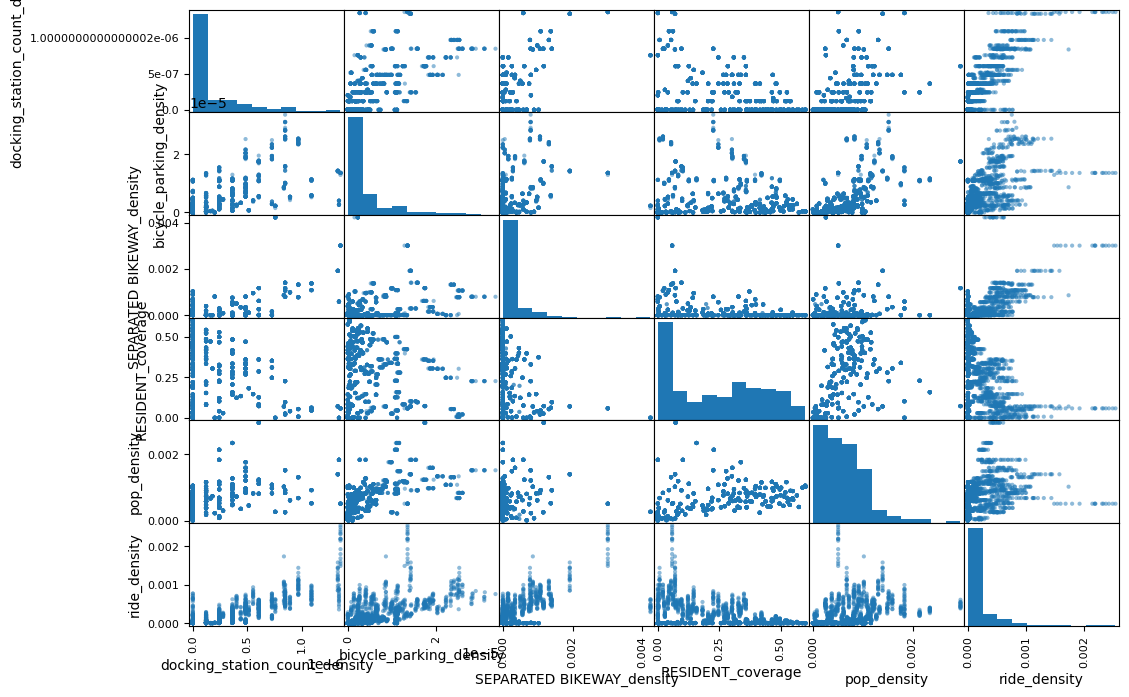

In [412]:
from pandas.plotting import scatter_matrix
attributes = ["docking_station_count_density", "bicycle_parking_density", "SEPARATED BIKEWAY_density",
 "RESIDENT_coverage", "pop_density", "ride_density"]
scatter_matrix(training_data.drop(columns = ['h3_index', 'started_at'])[attributes], figsize=(12, 8))

What we can see from this is clear lines where each hexagon is reproduced 16 times for the months. While there are trends, the small number of hexagons at resolution = 8 makes it a bit of an odd graph. 

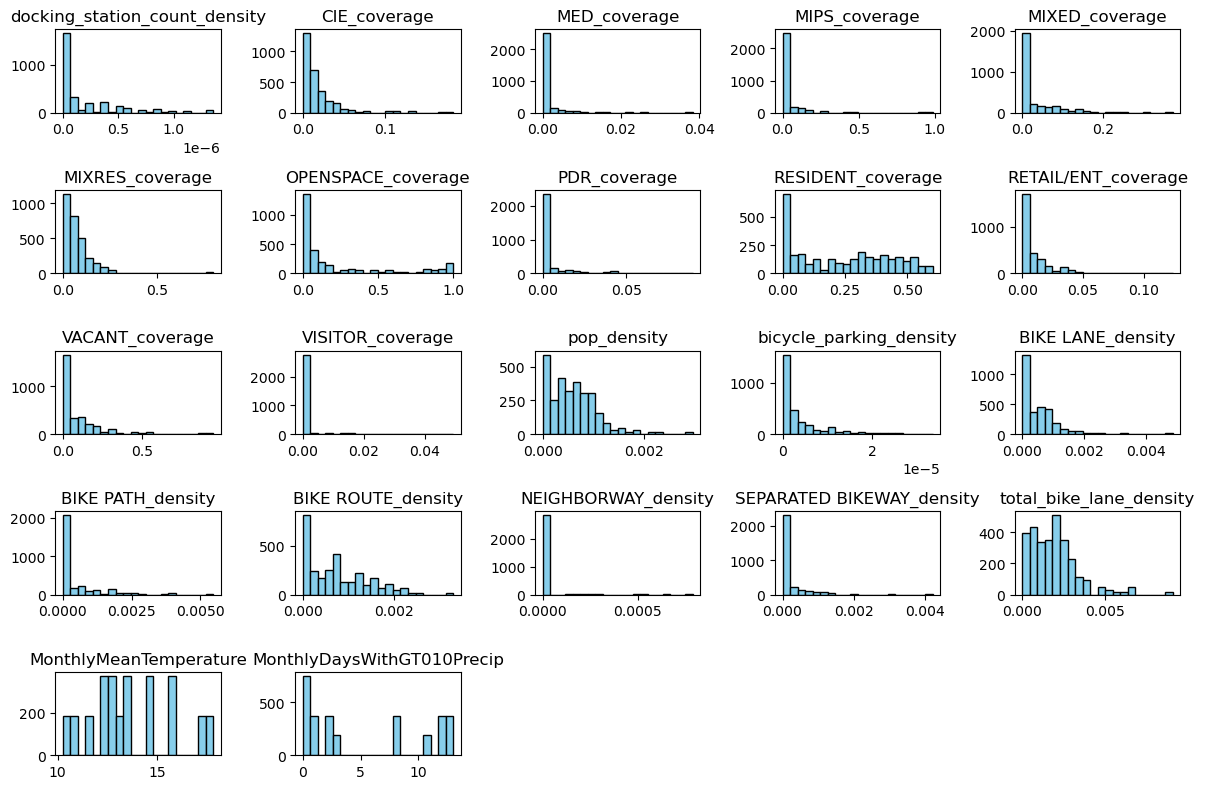

In [413]:
# Plot histograms for all numerical columns
X_train.hist(figsize=(12, 8), bins=20, grid=False, color='skyblue', edgecolor='black')

plt.tight_layout()  # Adjust subplots to fit into figure area
plt.show()

In [414]:
# remove_columns = ['MED_coverage', 'VISITOR_coverage', 'docking_station_count_density', 'BIKE LANE_density', 'BIKE PATH_density', 'BIKE ROUTE_density', 'NEIGHBORWAY_density', 'SEPARATED BIKEWAY_density']
# remove_columns = ['total_bike_lane_density']
remove_columns = []
X_train = X_train.drop(columns = remove_columns)
X_test = X_test.drop(columns = remove_columns)

In [415]:
y_train = training_data['ride_density']
y_test = test_data['ride_density']

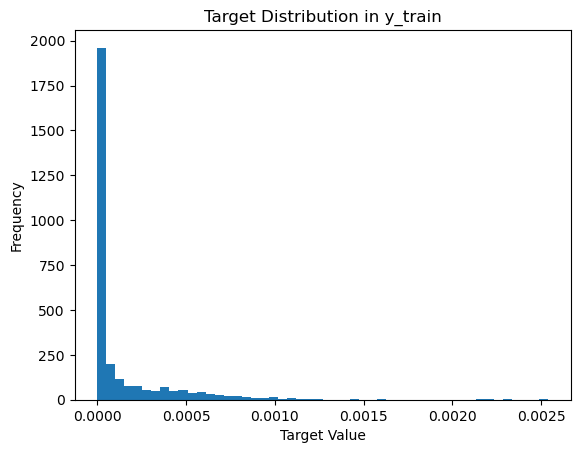

In [479]:
import matplotlib.pyplot as plt

plt.hist(y_train, bins=50)
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.title('Target Distribution in y_train')
plt.show()

### Correlation Matrix

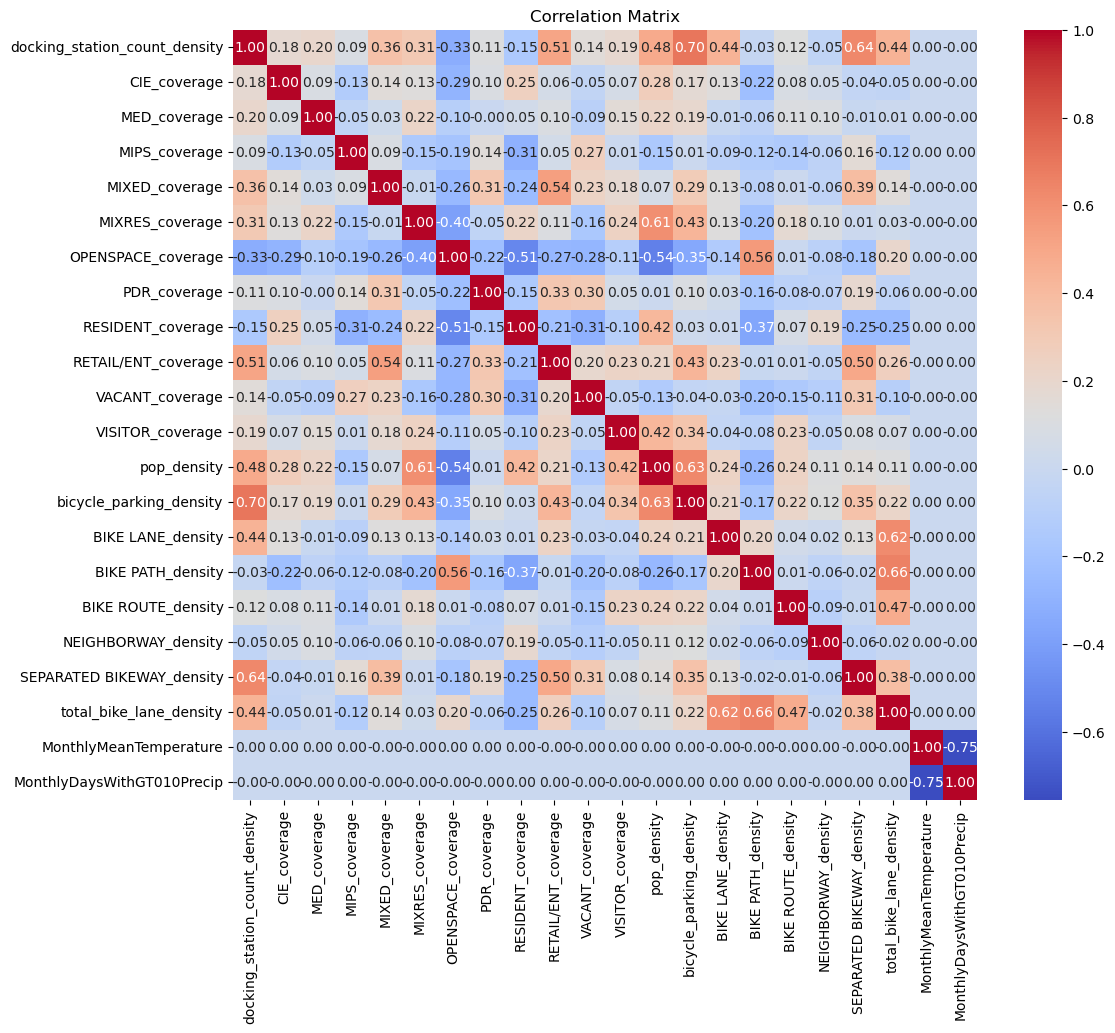

In [417]:
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = X_train.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Scaling Data

In [418]:
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler (do NOT refit on test data)
# X_test_scaled = scaler.transform(X_test)

### Testing Models
From sci-kit learn cheat sheet, I have 6 models to try:
##### If only some features important
* Lasso
* ElasticNet
##### If all features important
* RidgeRegression
* SVR(kernel="linear")
##### If not working
* SVR(kernel="rbf")
* Ensemble Regressors

In [333]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

lasso = Lasso()

from sklearn.model_selection import cross_val_score
scores = cross_val_score(lasso, X_train_scaled, y_train,
    scoring="neg_mean_squared_error", cv=10)
lasso_rmse_scores = np.sqrt(-scores)

In [334]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [335]:
display_scores(lasso_rmse_scores)

Scores: [0.00015015 0.00014508 0.00020377 0.00016067 0.00012176 0.00014974
 0.00014383 0.00015862 0.00062425 0.00050623]
Mean: 0.0002364112230657306
Standard deviation: 0.00016765636796312402


These are alright, but not excellent scores considering we are between .0005 and .0025

In [331]:
from sklearn.linear_model import ElasticNet

elasticnet = ElasticNet()

scores = cross_val_score(elasticnet, X_train_scaled, y_train,
    scoring="neg_mean_squared_error", cv=10)
elasticnet_rmse_scores = np.sqrt(-scores)

In [332]:
display_scores(elasticnet_rmse_scores)

Scores: [0.00015015 0.00014508 0.00020377 0.00016067 0.00012176 0.00014974
 0.00014383 0.00015862 0.00062425 0.00050623]
Mean: 0.0002364112230657306
Standard deviation: 0.00016765636796312402


Same as Lasso in this case

In [391]:
# Import libraries
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit


# Create the TimeSeriesSplit object, with a number of splits
tscv = TimeSeriesSplit(n_splits=5)

ridge= Ridge()

scores = cross_val_score(ridge, X_train_scaled, y_train,
    scoring="neg_mean_squared_error", cv=tscv)
ridge_rmse_scores = np.sqrt(-scores)

In [392]:
display_scores(ridge_rmse_scores)

Scores: [1.86647510e-04 9.48892275e-05 6.87433149e-05 1.15065089e-04
 3.00268583e-04]
Mean: 0.00015312274498113055
Standard deviation: 8.334893355148563e-05


In [305]:
# Import libraries
from sklearn.linear_model import Ridge

ridge= Ridge()

scores = cross_val_score(ridge, X_train, y_train,
    scoring="neg_mean_squared_error", cv=10)
ridge_rmse_scores = np.sqrt(-scores)

In [306]:
display_scores(ridge_rmse_scores)

Scores: [0.00011706 0.00014559 0.00021043 0.00011597 0.00010009 0.00036429
 0.00017334 0.00022525 0.00051613 0.00046944]
Mean: 0.00024375997689730778
Standard deviation: 0.00014447113670127543


Ridge is performing a lot better on scaled data, about the same on unscaled data. Is it overfitting or is that an actual improvement?

In [449]:
from sklearn.svm import SVR
param_grid = {'C':[.001, .01, .1, 1, 10, 100, 1000, 10000, 100000]}
# Initialize and train the SVR model with a linear kernel
svr_linear = SVR(kernel='linear')

# define the grid search
svr_linear_cv = GridSearchCV(svr_linear, param_grid, scoring='neg_mean_squared_error',cv=tscv,return_train_score=True)

#fit the grid search
svr_linear_cv.fit(X_train_scaled, y_train)

# best estimator
print(svr_linear_cv.best_estimator_)

# best model
svr_linear_cv_best = svr_linear_cv.best_estimator_
svr_linear_cv_best.fit(X_train_scaled, y_train)

cvres = svr_linear_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

SVR(C=0.001, kernel='linear')
0.0010364616739639203 {'C': 0.001}
0.0010364616739639203 {'C': 0.01}
0.0010364616739639203 {'C': 0.1}
0.0010364616739639203 {'C': 1}
0.0010364616739639203 {'C': 10}
0.0010364616739639203 {'C': 100}
0.0010364616739639203 {'C': 1000}
0.0010364616739639203 {'C': 10000}
0.0010364616739639203 {'C': 100000}


In [268]:
display_scores(svr_linear_rmse_scores)

Scores: [6.80176208e-05 5.45386937e-05 8.03753801e-05 8.18466751e-05
 7.94917026e-05 6.63711276e-05 8.88495747e-05 1.02574698e-04
 3.38443861e-04 2.98064916e-04]
Mean: 0.00012585742498798079
Standard deviation: 9.740936604705386e-05


Performs exactly like Ridge

In [458]:
# Initialize and train the SVR model with an rbf kernel

from sklearn.preprocessing import MinMaxScaler
param_grid = {'C':[.001, .01, .1, 1, 10, 100, 1000, 10000, 100000],
             'gamma':[.001, .01, .1, 1, 10, 100, 1000, 10000, 100000]}
svr_rbf = SVR(kernel='rbf')

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# define the grid search
svr_rbf_cv = GridSearchCV(svr_rbf, param_grid, scoring='neg_mean_squared_error',cv=tscv,return_train_score=True)

#fit the grid search
svr_rbf_cv.fit(X_train_scaled, y_train_scaled)

# best estimator
print(svr_rbf_cv.best_estimator_)

# best model
svr_rbf_cv_best = svr_rbf_cv.best_estimator_
svr_rbf_cv_best.fit(X_train_scaled, y_train_scaled)

cvres = svr_rbf_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

SVR(C=10, gamma=0.001)
0.11988970616437941 {'C': 0.001, 'gamma': 0.001}
0.11540970366795272 {'C': 0.001, 'gamma': 0.01}
0.1188539646990074 {'C': 0.001, 'gamma': 0.1}
0.12099751150298281 {'C': 0.001, 'gamma': 1}
0.12127735593266022 {'C': 0.001, 'gamma': 10}
0.12131039507705636 {'C': 0.001, 'gamma': 100}
0.12132758065587891 {'C': 0.001, 'gamma': 1000}
0.12132994563075661 {'C': 0.001, 'gamma': 10000}
0.12132994569806219 {'C': 0.001, 'gamma': 100000}
0.1121895058118291 {'C': 0.01, 'gamma': 0.001}
0.09527737653731533 {'C': 0.01, 'gamma': 0.01}
0.1086719171708688 {'C': 0.01, 'gamma': 0.1}
0.11887327219788457 {'C': 0.01, 'gamma': 1}
0.12108100874912697 {'C': 0.01, 'gamma': 10}
0.12147860151427266 {'C': 0.01, 'gamma': 100}
0.12164767563826673 {'C': 0.01, 'gamma': 1000}
0.12168163671211595 {'C': 0.01, 'gamma': 10000}
0.12168163794381044 {'C': 0.01, 'gamma': 100000}
0.0891972909160857 {'C': 0.1, 'gamma': 0.001}
0.07304162546687912 {'C': 0.1, 'gamma': 0.01}
0.09364296700840165 {'C': 0.1, 'gamma':

In [465]:
pd.DataFrame(y_train_scaled).describe()

0
count  2992.000000
mean      0.053587
std       0.108514
min       0.000000
25%       0.000000
50%       0.001767
75%       0.054109
max       1.000000

In [270]:
display_scores(svr_rbf_rmse_scores)

Scores: [6.80176208e-05 5.45386937e-05 8.03753801e-05 8.18466751e-05
 7.94917026e-05 6.63711276e-05 8.88495747e-05 1.02574698e-04
 3.38443861e-04 2.98064916e-04]
Mean: 0.00012585742498798079
Standard deviation: 9.740936604705386e-05


Performs the same as the two above

In [436]:
# Import necessary libraries
from sklearn.ensemble import VotingRegressor

# Initialize the Voting Regressor
voting_regressor = VotingRegressor(estimators=[('ridge', ridge), ('elasticnet', elasticnet)])

scores = cross_val_score(voting_regressor, X_train_scaled, y_train,
    scoring="neg_mean_squared_error", cv=tscv)
regressor_rmse_scores = np.sqrt(-scores)

In [437]:
display_scores(regressor_rmse_scores)

Scores: [0.00029526 0.0002936  0.00031571 0.00023809 0.00032181]
Mean: 0.000292892630771391
Standard deviation: 2.9547395002697496e-05


### Tuning Hyperparameters

Based on these results, I will tune the hyperparameters for Lasso, Ridge, SVR Linear, SVR rbf, Random Forest Regressor, Decision Tree Regressor, before testing them in Voting regressor to see if we get better values.

In [489]:
# https://stackoverflow.com/questions/57376860/how-to-run-gridsearchcv-with-ridge-regression-in-sklearn

from sklearn.model_selection import GridSearchCV

# parameters from ChatGPT
param_grid = {'alpha':[.001, .01, .1, 1, 10, 100, 1000, 10000, 100000],
    'solver': ['auto', 'svd', 'lsqr', 'sparse_cg', 'sag'],
    'max_iter': [1000, 5000],
    'tol': [1e-3, 1e-4]}

# define the model/ estimator
model = Ridge()

# define the grid search
Ridge_reg = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error',cv=tscv,return_train_score=True)

#fit the grid search
Ridge_reg.fit(X_train_scaled, y_train)

# best estimator
print(Ridge_reg.best_estimator_)

# best model
Ridge_reg_best = Ridge_reg.best_estimator_
Ridge_reg_best.fit(X_train_scaled, y_train)



scores = cross_val_score(Ridge_reg_best, X_train_scaled, y_train,
    scoring="r2", cv=tscv)
#voting_regressor_rmse_scores = np.sqrt(-scores)
mean_cv_score = scores.mean()

training_score = Ridge_reg_best.score(X_train_scaled, y_train)
print(f"Training R² Score: {training_score:.4f}")
print(f"Mean Cross-validation R² Score: {mean_cv_score:.4f}")

if training_score > mean_cv_score + 0.05:
    print("The model is overfitting.")
elif training_score < 0.5 and mean_cv_score < 0.5:
    print("The model is underfitting.")
else:
    print("The model is a good fit.")

Ridge(alpha=10, max_iter=1000, solver='sparse_cg', tol=0.001)
Training R² Score: 0.8094
Mean Cross-validation R² Score: 0.7850
The model is a good fit.


In [420]:
cvres = Ridge_reg.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.00013542671266712108 {'alpha': 0.001, 'max_iter': 1000, 'solver': 'auto', 'tol': 0.001}
0.00013542671266712108 {'alpha': 0.001, 'max_iter': 1000, 'solver': 'auto', 'tol': 0.0001}
0.00013542671266712067 {'alpha': 0.001, 'max_iter': 1000, 'solver': 'svd', 'tol': 0.001}
0.00013542671266712067 {'alpha': 0.001, 'max_iter': 1000, 'solver': 'svd', 'tol': 0.0001}
0.00013525134602425078 {'alpha': 0.001, 'max_iter': 1000, 'solver': 'lsqr', 'tol': 0.001}
0.00013542772488350387 {'alpha': 0.001, 'max_iter': 1000, 'solver': 'lsqr', 'tol': 0.0001}
0.0001352547618158646 {'alpha': 0.001, 'max_iter': 1000, 'solver': 'sparse_cg', 'tol': 0.001}
0.00013542772113065652 {'alpha': 0.001, 'max_iter': 1000, 'solver': 'sparse_cg', 'tol': 0.0001}
0.00013504765978054103 {'alpha': 0.001, 'max_iter': 1000, 'solver': 'sag', 'tol': 0.001}
0.0001353889663182908 {'alpha': 0.001, 'max_iter': 1000, 'solver': 'sag', 'tol': 0.0001}
0.00013542671266712108 {'alpha': 0.001, 'max_iter': 5000, 'solver': 'auto', 'tol': 0.001}
0

In [490]:
feature_importances = Ridge_reg_best.coef_
sorted(zip(feature_importances, attributes), reverse=True)

[(0.00015900269913983724, 'docking_station_count_density'),
 (7.193694629012712e-05, 'bicycle_parking_density'),
 (6.29007800323752e-05, 'SEPARATED BIKEWAY_density'),
 (2.2270924828901746e-05, 'BIKE PATH_density'),
 (2.1291099966445884e-05, 'total_bike_lane_density'),
 (1.523905068173876e-05, 'VISITOR_coverage'),
 (1.2766095493573706e-05, 'MonthlyMeanTemperature'),
 (3.452539805331957e-06, 'MIXED_coverage'),
 (2.283969791218916e-06, 'NEIGHBORWAY_density'),
 (2.2682056221253757e-06, 'MIXRES_coverage'),
 (-2.1807667928229303e-07, 'MIPS_coverage'),
 (-3.4558972627743205e-06, 'MonthlyDaysWithGT010Precip'),
 (-3.6113467893239395e-06, 'PDR_coverage'),
 (-8.91031282241963e-06, 'VACANT_coverage'),
 (-9.333751920594152e-06, 'BIKE ROUTE_density'),
 (-9.894038319587565e-06, 'CIE_coverage'),
 (-1.1357577992786841e-05, 'pop_density'),
 (-1.1486562291877222e-05, 'MED_coverage'),
 (-1.5030063696084213e-05, 'OPENSPACE_coverage'),
 (-1.6603791663787493e-05, 'RESIDENT_coverage'),
 (-2.0284965791238952e-

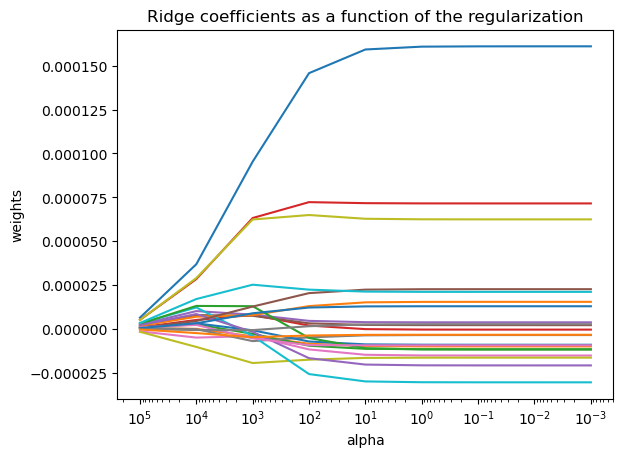

In [422]:
alphas = [.001, .01, .1, 1, 10, 100, 1000, 10000, 100000]
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train_scaled, y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [477]:
from sklearn.ensemble import RandomForestRegressor

param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]
rand_for = RandomForestRegressor()
grid_search_ran_forest = GridSearchCV(rand_for, param_grid, cv=tscv,
 scoring='neg_mean_squared_error',
return_train_score=True)
grid_search_ran_forest.fit(X_train_scaled, y_train)

grid_search_ran_forest_best = grid_search_ran_forest.best_estimator_
grid_search_ran_forest_best.fit(X_train_scaled, y_train)



scores = cross_val_score(grid_search_ran_forest_best, X_train_scaled, y_train,
    scoring="r2", cv=tscv)
#voting_regressor_rmse_scores = np.sqrt(-scores)
mean_cv_score = scores.mean()

training_score = grid_search_ran_forest_best.score(X_train_scaled, y_train)
print(f"Training R² Score: {training_score:.4f}")
print(f"Mean Cross-validation R² Score: {mean_cv_score:.4f}")

if training_score > mean_cv_score + 0.05:
    print("The model is overfitting.")
elif training_score < 0.5 and mean_cv_score < 0.5:
    print("The model is underfitting.")
else:
    print("The model is a good fit.")

Training R² Score: 1.0000
Mean Cross-validation R² Score: 0.9523
The model is a good fit.


In [478]:
print(X_train.duplicated().sum())
print(y_train.duplicated().sum())


0
1374


In [424]:
cvres = grid_search_ran_forest.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

7.431469504724851e-05 {'max_features': 2, 'n_estimators': 3}
6.528287592016382e-05 {'max_features': 2, 'n_estimators': 10}
6.788635199186683e-05 {'max_features': 2, 'n_estimators': 30}
6.523427659741033e-05 {'max_features': 4, 'n_estimators': 3}
6.425199603777052e-05 {'max_features': 4, 'n_estimators': 10}
6.477303066466689e-05 {'max_features': 4, 'n_estimators': 30}
6.872737431936176e-05 {'max_features': 6, 'n_estimators': 3}
6.361482149587597e-05 {'max_features': 6, 'n_estimators': 10}
6.397213061788343e-05 {'max_features': 6, 'n_estimators': 30}
7.356910783257004e-05 {'max_features': 8, 'n_estimators': 3}
6.564703685459967e-05 {'max_features': 8, 'n_estimators': 10}
6.548694541453318e-05 {'max_features': 8, 'n_estimators': 30}
6.854765262724618e-05 {'max_features': 10, 'n_estimators': 3}
6.48301909829614e-05 {'max_features': 10, 'n_estimators': 10}
6.479056552471154e-05 {'max_features': 10, 'n_estimators': 30}
6.820419952652741e-05 {'max_features': 12, 'n_estimators': 3}
6.356349922

In [425]:
feature_importances = grid_search_ran_forest_best.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32063813636910005, 'docking_station_count_density'),
 (0.04735822421562226, 'RESIDENT_coverage'),
 (0.039135345400263755, 'pop_density'),
 (0.02553103944696461, 'ride_density'),
 (0.02173775505348436, 'bicycle_parking_density'),
 (0.00517298122843733, 'SEPARATED BIKEWAY_density')]

In [476]:
from sklearn.tree import DecisionTreeRegressor

param_grid = [
 {'max_depth': [1, 3, 10, 30, 60], 'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]}
 ]
tree_reg = DecisionTreeRegressor()
grid_search_decision_tree = GridSearchCV(tree_reg, param_grid, cv=tscv,
 scoring='r2',
return_train_score=True)
grid_search_decision_tree.fit(X_train_scaled, y_train)

grid_search_decision_tree_best = grid_search_decision_tree.best_estimator_

scores = cross_val_score(grid_search_decision_tree_best, X_train_scaled, y_train,
    scoring="r2", cv=tscv)
#voting_regressor_rmse_scores = np.sqrt(-scores)
mean_cv_score = scores.mean()

grid_search_decision_tree_best.fit(X_train_scaled, y_train)
training_score = grid_search_decision_tree_best.score(X_train_scaled, y_train)
print(f"Training R² Score: {training_score:.4f}")
print(f"Mean Cross-validation R² Score: {mean_cv_score:.4f}")

if training_score > mean_cv_score + 0.05:
    print("The model is overfitting.")
elif training_score < 0.5 and mean_cv_score < 0.5:
    print("The model is underfitting.")
else:
    print("The model is a good fit.")

Training R² Score: 0.9961
Mean Cross-validation R² Score: 0.9429
The model is overfitting.


In [427]:
feature_importances = grid_search_decision_tree_best.feature_importances_

In [428]:
attributes = X_train.columns
sorted(zip(feature_importances, attributes), reverse=True)

[(0.7756624437340037, 'docking_station_count_density'),
 (0.06365017851164635, 'MIPS_coverage'),
 (0.032662299884929864, 'pop_density'),
 (0.020974875430352903, 'MonthlyMeanTemperature'),
 (0.02089371754679088, 'bicycle_parking_density'),
 (0.019946526160491723, 'RETAIL/ENT_coverage'),
 (0.017367470915421193, 'PDR_coverage'),
 (0.01329966030365343, 'MonthlyDaysWithGT010Precip'),
 (0.007319990912515558, 'SEPARATED BIKEWAY_density'),
 (0.00667937324674838, 'BIKE PATH_density'),
 (0.00564604309531012, 'VISITOR_coverage'),
 (0.0026851350091692074, 'BIKE LANE_density'),
 (0.002500610728250349, 'MED_coverage'),
 (0.002251440123808251, 'MIXED_coverage'),
 (0.0020892729153166338, 'RESIDENT_coverage'),
 (0.0019250903111662852, 'VACANT_coverage'),
 (0.0012971108274662298, 'OPENSPACE_coverage'),
 (0.0009585485446937079, 'BIKE ROUTE_density'),
 (0.0008512508451388889, 'total_bike_lane_density'),
 (0.0007767919904105963, 'MIXRES_coverage'),
 (0.0005619696297229477, 'CIE_coverage'),
 (1.993329926999

In [429]:
cvres = grid_search_decision_tree.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.0002465554306662203 {'max_depth': 1, 'max_features': 2}
0.00022500768299550973 {'max_depth': 1, 'max_features': 4}
0.00024162654317621388 {'max_depth': 1, 'max_features': 6}
0.00020389957117920778 {'max_depth': 1, 'max_features': 8}
0.00022130628043455657 {'max_depth': 1, 'max_features': 10}
0.00022546514138489308 {'max_depth': 1, 'max_features': 12}
0.00021028160119058965 {'max_depth': 1, 'max_features': 14}
0.00019946164955197583 {'max_depth': 1, 'max_features': 16}
0.00019946164955197585 {'max_depth': 1, 'max_features': 18}
0.000192688678628431 {'max_depth': 1, 'max_features': 20}
0.00019268867862843098 {'max_depth': 1, 'max_features': 22}
0.00016618901935871232 {'max_depth': 3, 'max_features': 2}
0.0001584857638454942 {'max_depth': 3, 'max_features': 4}
0.00013858965850732847 {'max_depth': 3, 'max_features': 6}
0.00014249011669175004 {'max_depth': 3, 'max_features': 8}
0.00013072275780321658 {'max_depth': 3, 'max_features': 10}
0.00012623334308365226 {'max_depth': 3, 'max_feature

In [473]:
# Initialize the Voting Regressor
voting_regressor = VotingRegressor(estimators=[('Ridge_reg_best', Ridge_reg_best), 
                                               ('grid_search_ran_forest_best', grid_search_ran_forest_best),
                                              ('grid_search_decision_tree_best', grid_search_decision_tree_best)])

scores = cross_val_score(voting_regressor, X_train_scaled, y_train,
    scoring="r2", cv=tscv)
#voting_regressor_rmse_scores = np.sqrt(-scores)
mean_cv_score = scores.mean()

voting_regressor.fit(X_train_scaled, y_train)
training_score = voting_regressor.score(X_train_scaled, y_train)
print(f"Training R² Score: {training_score:.4f}")
print(f"Mean Cross-validation R² Score: {mean_cv_score:.4f}")

if training_score > mean_cv_score + 0.05:
    print("The model is overfitting.")
elif training_score < 0.5 and mean_cv_score < 0.5:
    print("The model is underfitting.")
else:
    print("The model is a good fit.")

Training R² Score: 0.9788
Mean Cross-validation R² Score: 0.9278
The model is overfitting.


In [468]:
display_scores(voting_regressor_rmse_scores)

Scores: [1.02856124e-04 6.16054986e-05 6.02661769e-05 5.02606510e-05
 1.02111726e-04]
Mean: 7.542003537959194e-05
Standard deviation: 2.2443978251149467e-05


Great, got some low scores with that, time to test the model.